# House Prices - Advanced Regression Techniques

#### Импорт библиотек

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import optuna

import warnings
warnings.filterwarnings('ignore')

import kaggle
api = kaggle.KaggleApi()
api.authenticate()

#### Загрузим данные

In [2]:
data = pd.read_csv('data/train.csv')
data

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

In [3]:
data.isna().sum()[data.isna().sum() != 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

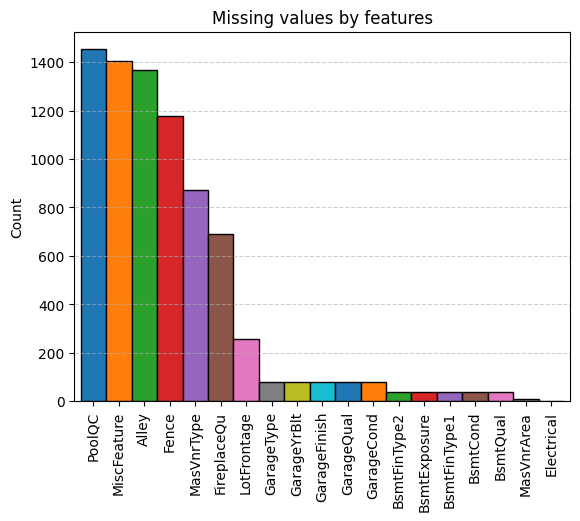

In [4]:
data.isna().sum()[data.isna().sum() != 0].sort_values(ascending=False).plot(kind='bar', edgecolor='black', color=mcolors.TABLEAU_COLORS, width=1)
plt.title('Missing values by features')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

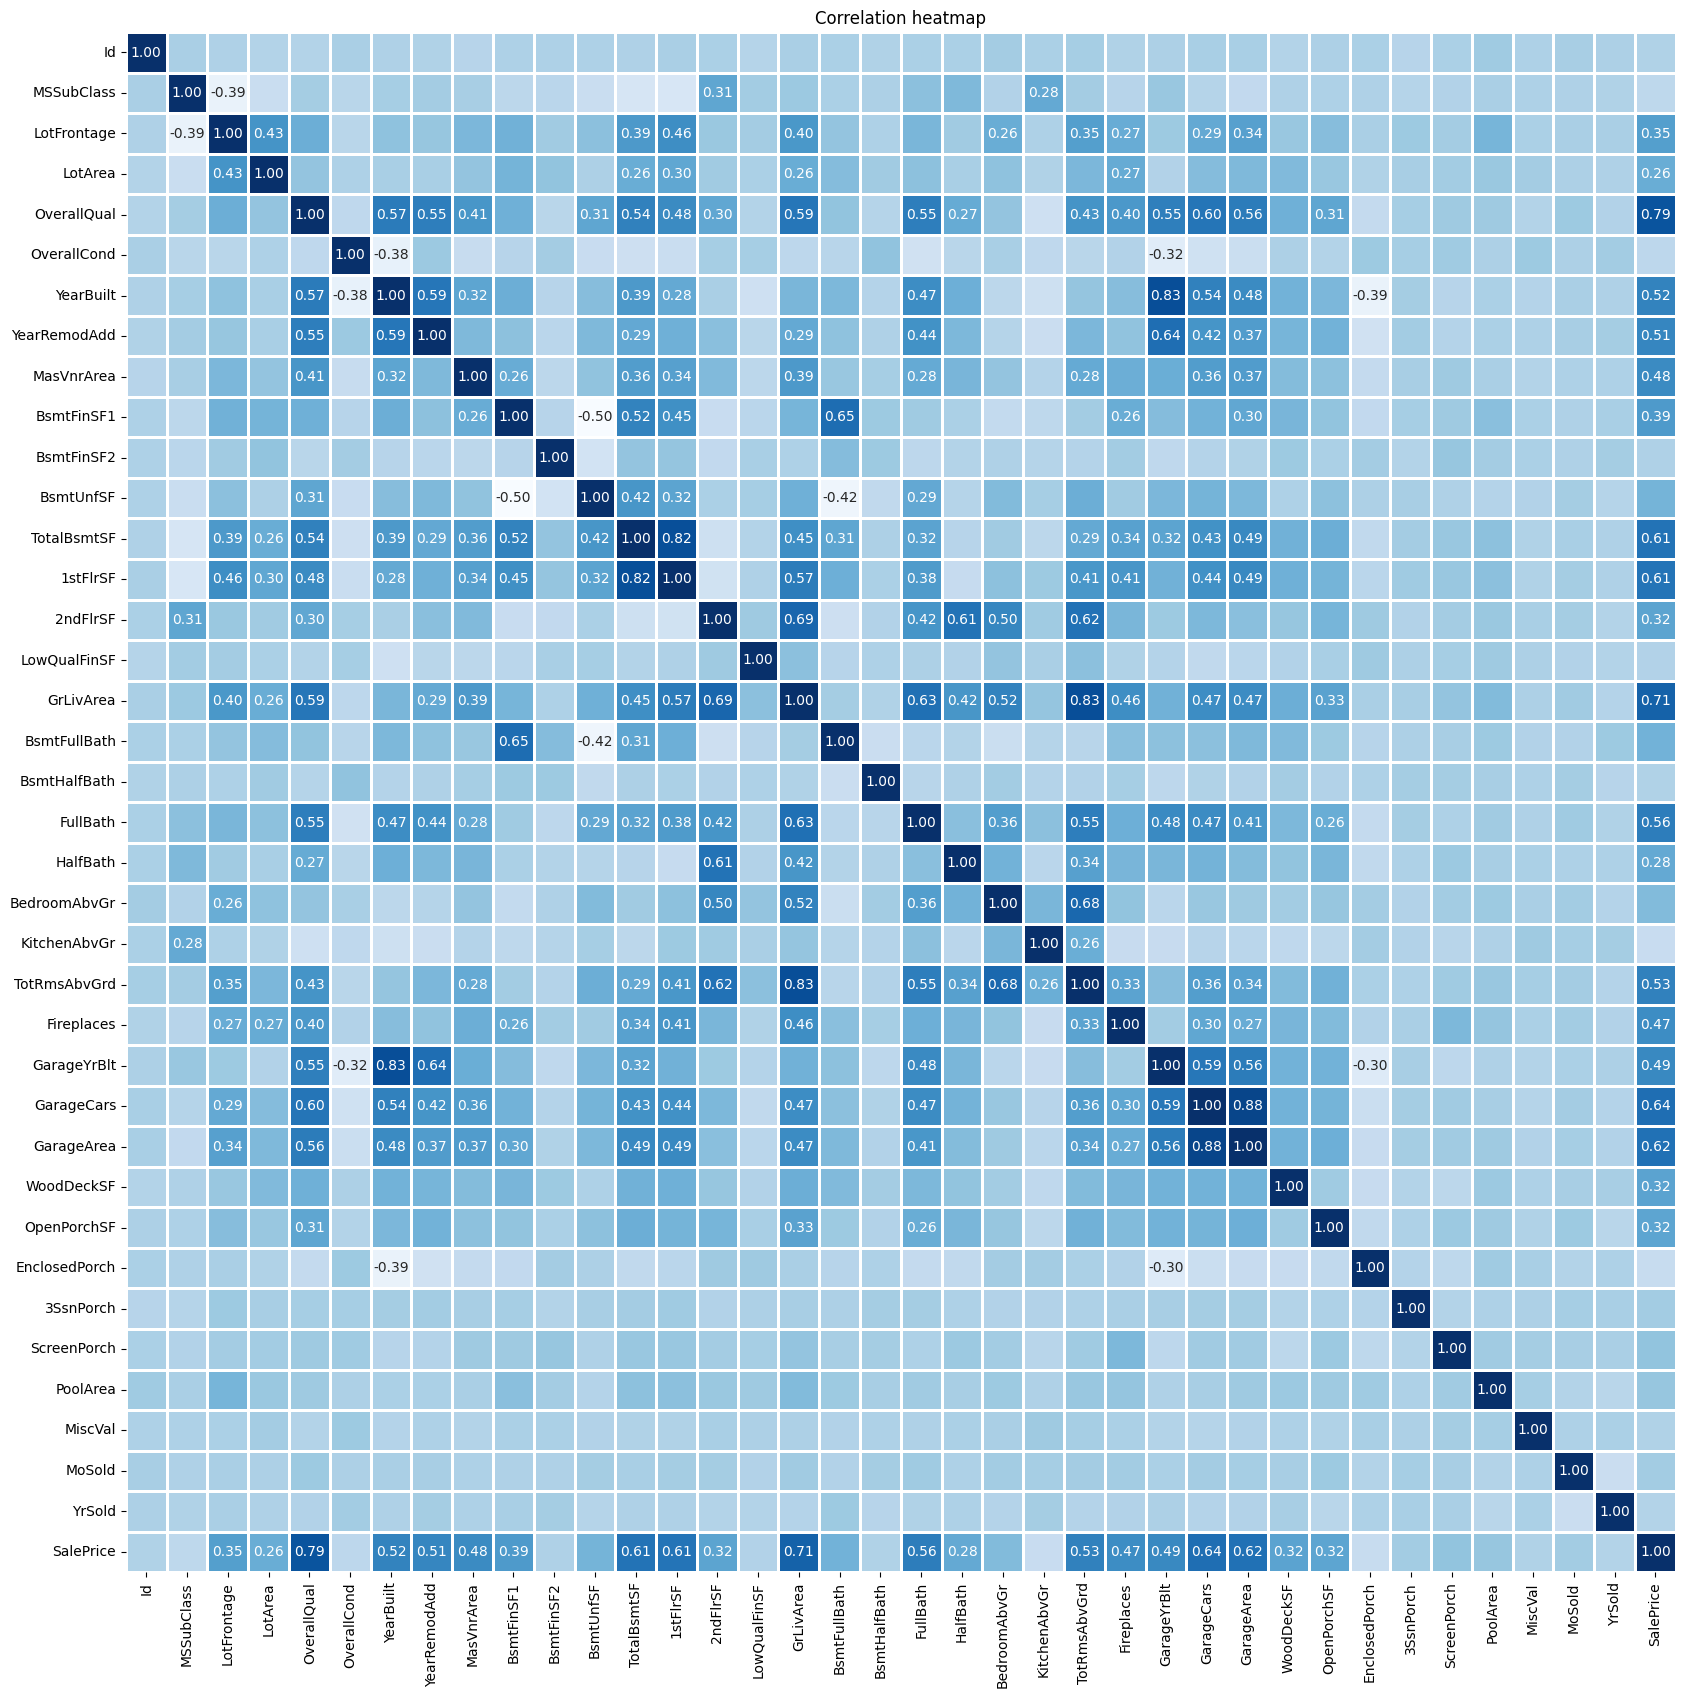

In [5]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2, cbar=False)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}' if abs(float(t.get_text())) > 0.25 else '')
plt.title('Correlation heatmap')
plt.show()

In [6]:
def make_heatmap(data, figsize=None):
    plt.figure(figsize=figsize)
    ax = sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2, cbar=False)
    for t in ax.texts: 
        t.set_text(f'{float(t.get_text()):.2f}')
    plt.title('Correlation heatmap')
    plt.show()

#### Посмотрим на данные, начнем с таргета - `SalePrice`

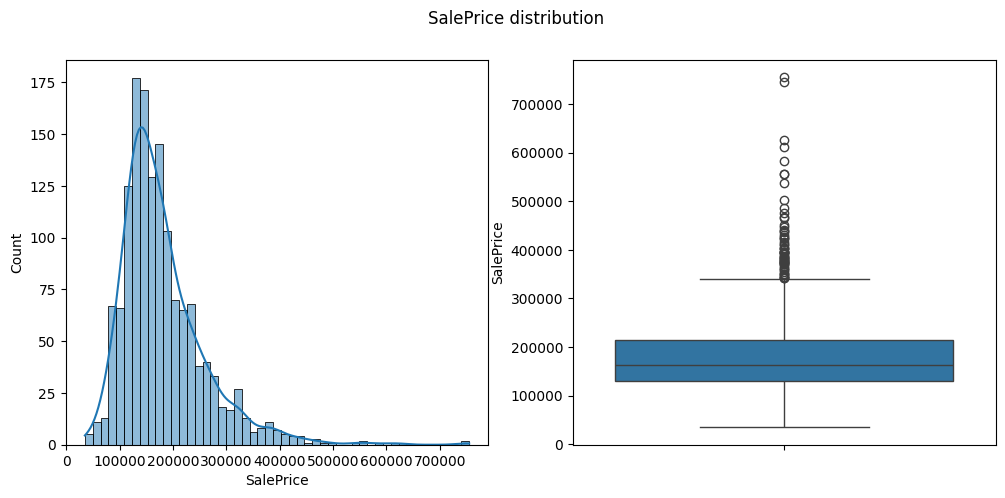

In [7]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=data['SalePrice'], kde=True, ax=axes[0])
sns.boxplot(data=data['SalePrice'], ax=axes[1])
plt.suptitle('SalePrice distribution')
plt.show()

In [8]:
# добавим логарифм таргета
data['LogSalePrice'] = np.log(data['SalePrice'])

##### Будем смотреть на группы признаков

##### Контекстные признаки

`MoSold` — месяц продажи. 

`YrSold` — год продажи. 

`SaleType` — тип сделки.  

`SaleCondition` — условия сделки.


In [9]:
context_features = ['MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'LogSalePrice']

In [10]:
context_features = ['MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'LogSalePrice']
context_data = data[context_features].copy()
context_data['MonthAfter2K6'] = (context_data['YrSold'] - 2006) * 12 + context_data['MoSold']

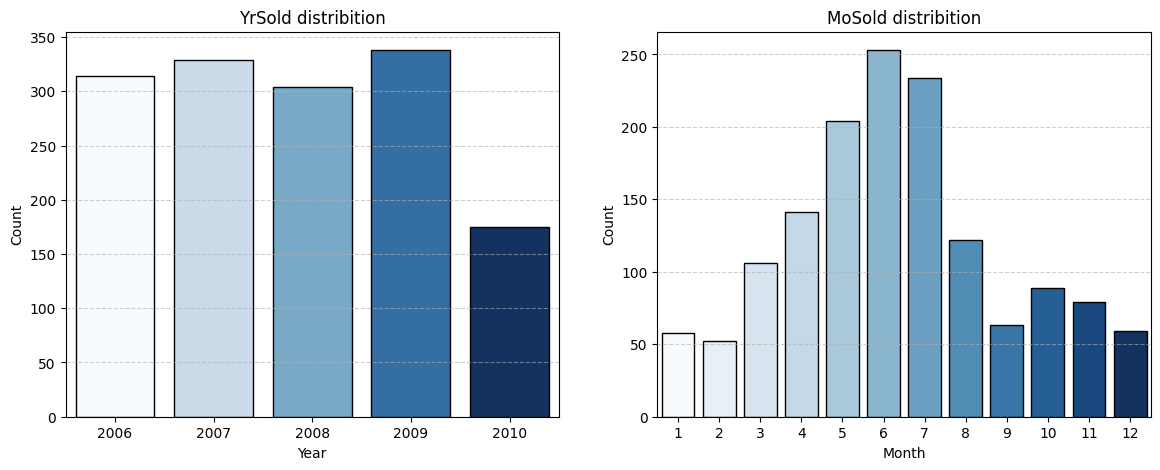

In [11]:
_, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x='YrSold', data=context_data, palette='Blues', edgecolor='black', hue='YrSold', legend=False, ax=axes[0])
axes[0].set_title('YrSold distribition')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
sns.countplot(x='MoSold', data=context_data, palette='Blues', edgecolor='black', hue='MoSold', legend=False, ax=axes[1])
axes[1].set_title('MoSold distribition')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

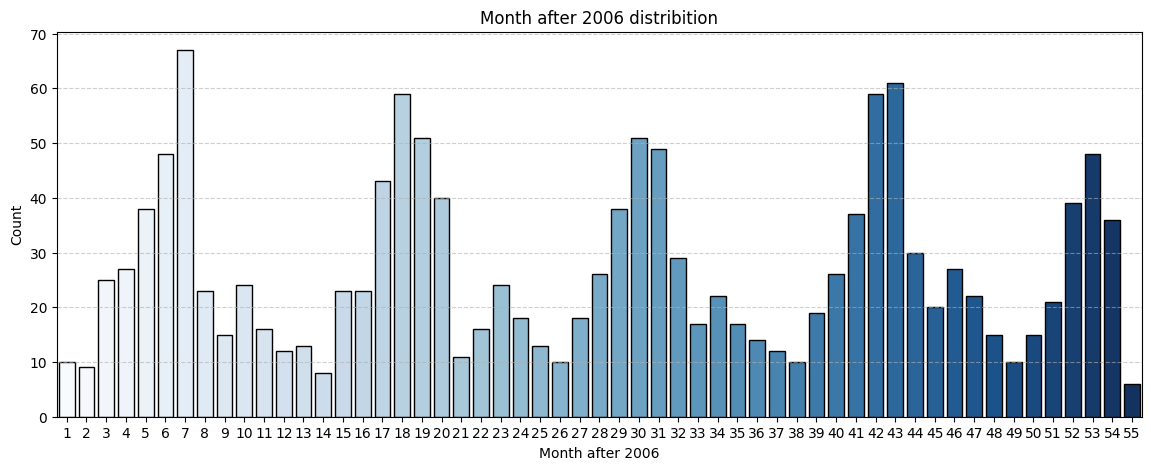

In [12]:
plt.figure(figsize=(14, 5))
sns.countplot(x='MonthAfter2K6', data=context_data, palette='Blues', edgecolor='black', hue='MonthAfter2K6', legend=False)
plt.title('Month after 2006 distribition')
plt.xlabel('Month after 2006')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

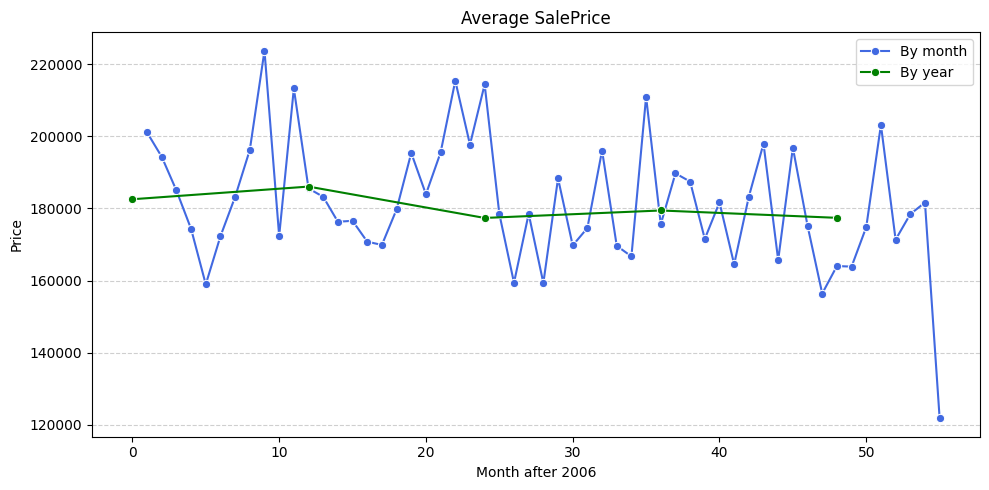

In [13]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='MonthAfter2K6', y='SalePrice', data=context_data.groupby('MonthAfter2K6', as_index=False)['SalePrice'].mean(), marker='o', color='royalblue', label='By month')
sns.lineplot(x=(context_data.groupby('YrSold', as_index=False)['SalePrice'].mean()['YrSold'] - 2006) * 12, y='SalePrice', data=context_data.groupby('YrSold', as_index=False)['SalePrice'].mean(), marker='o', color='green', label='By year')
plt.title('Average SalePrice')
plt.xlabel('Month after 2006')
plt.ylabel('Price')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
context_data['SaleType_num'] = pd.Categorical(context_data['SaleType']).codes
context_data['SaleCondition_num'] = pd.Categorical(context_data['SaleCondition']).codes

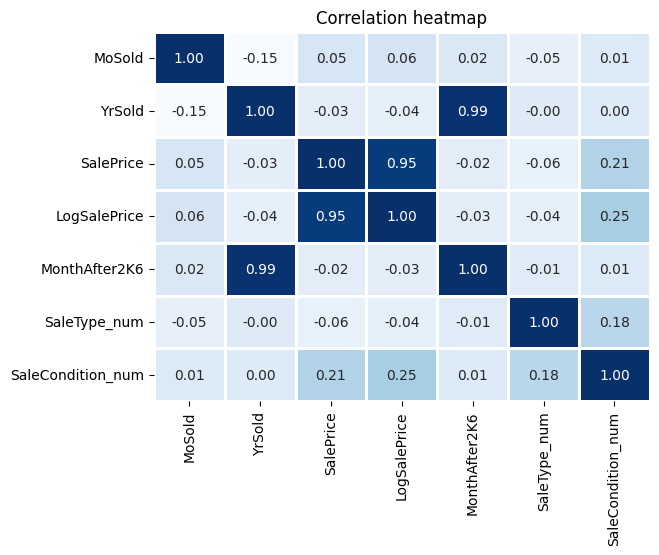

In [15]:
make_heatmap(context_data)

In [16]:
del context_data

##### Земельные признаки

In [17]:
land_features = [
    'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'MSZoning'
]
land_data = data[land_features + ['LogSalePrice', 'SalePrice']].copy()

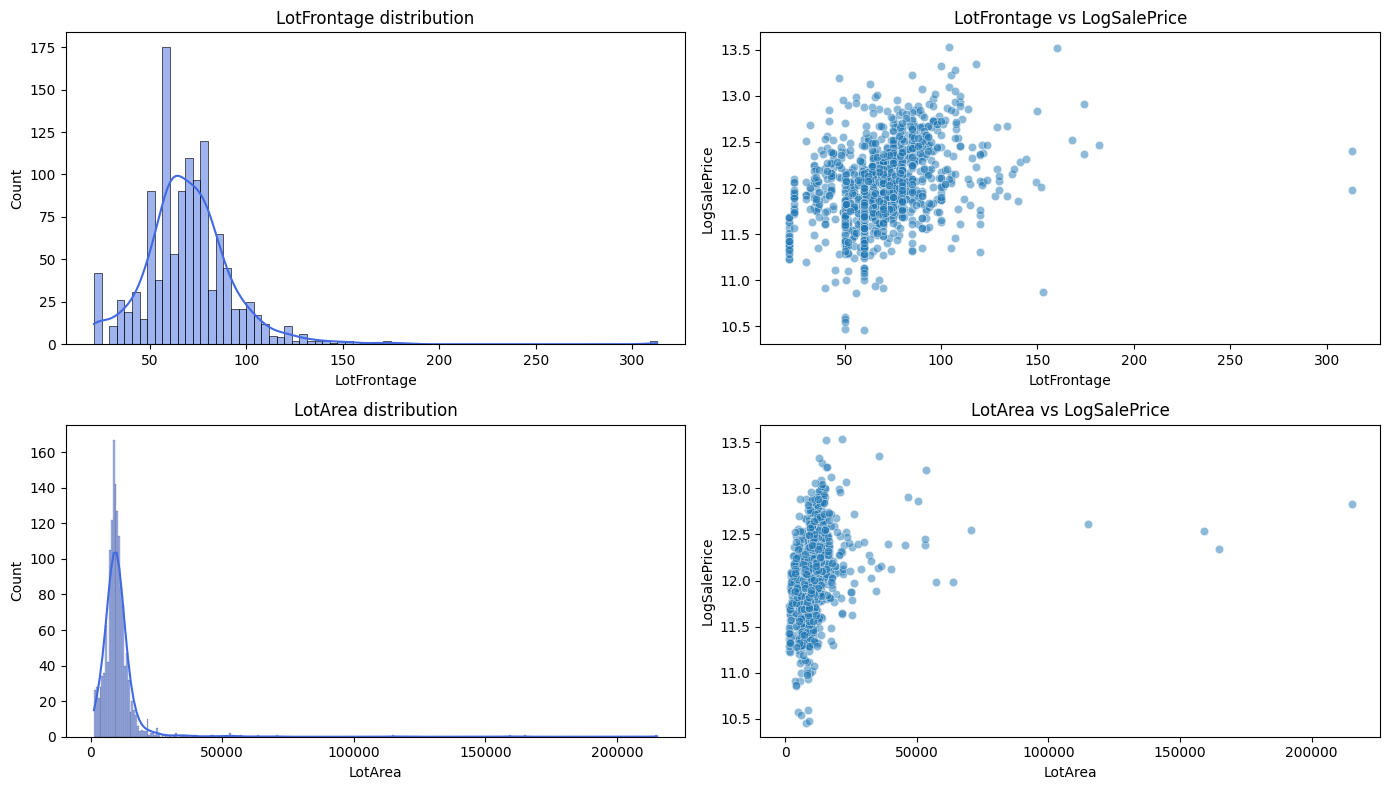

In [18]:
num_feats = ['LotFrontage', 'LotArea']
fig, axes = plt.subplots(len(num_feats), 2, figsize=(14, 4 * len(num_feats)))
for i, col in enumerate(num_feats):
    sns.histplot(land_data[col], kde=True, ax=axes[i, 0], color='royalblue')
    axes[i, 0].set_title(f'{col} distribution')
    sns.scatterplot(x=col, y='LogSalePrice', data=land_data, ax=axes[i, 1], alpha=0.5)
    axes[i, 1].set_title(f'{col} vs LogSalePrice')
plt.tight_layout()
plt.show()

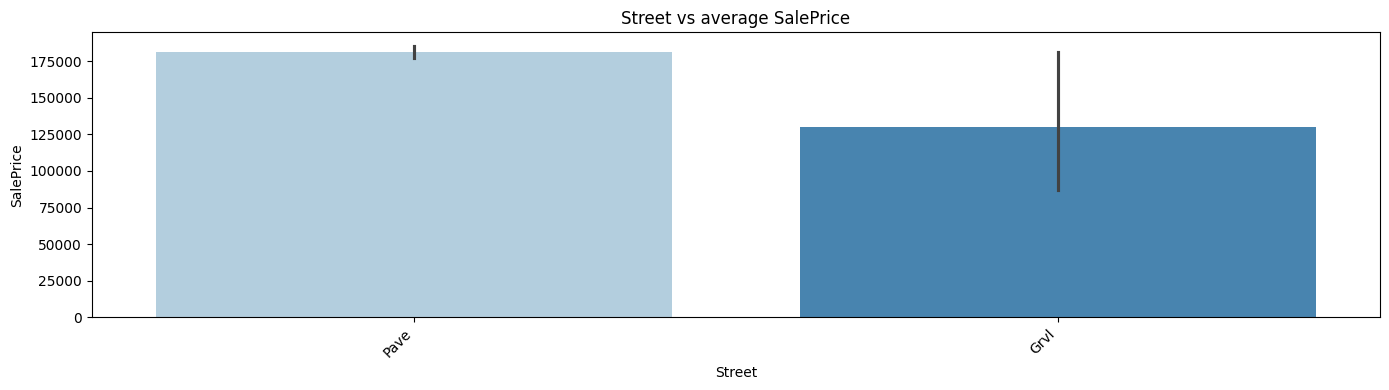

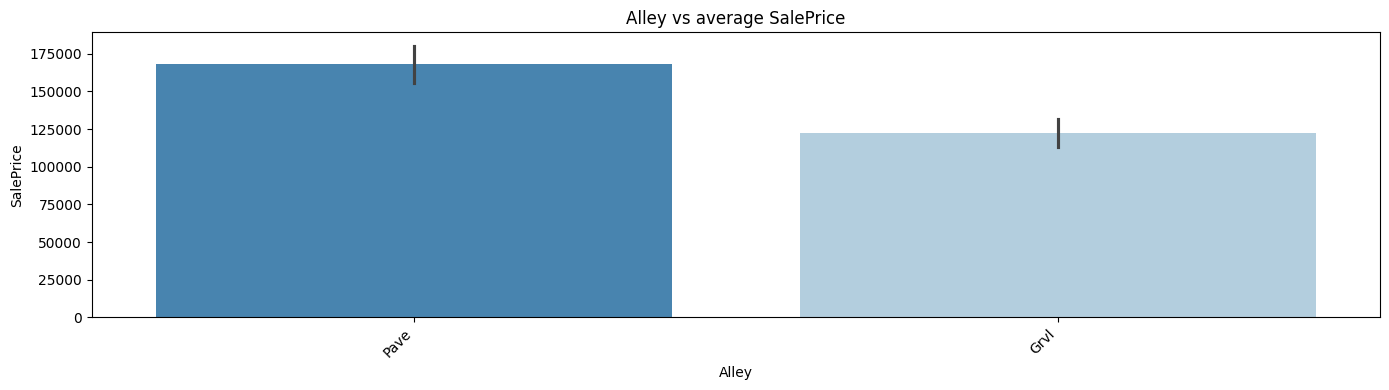

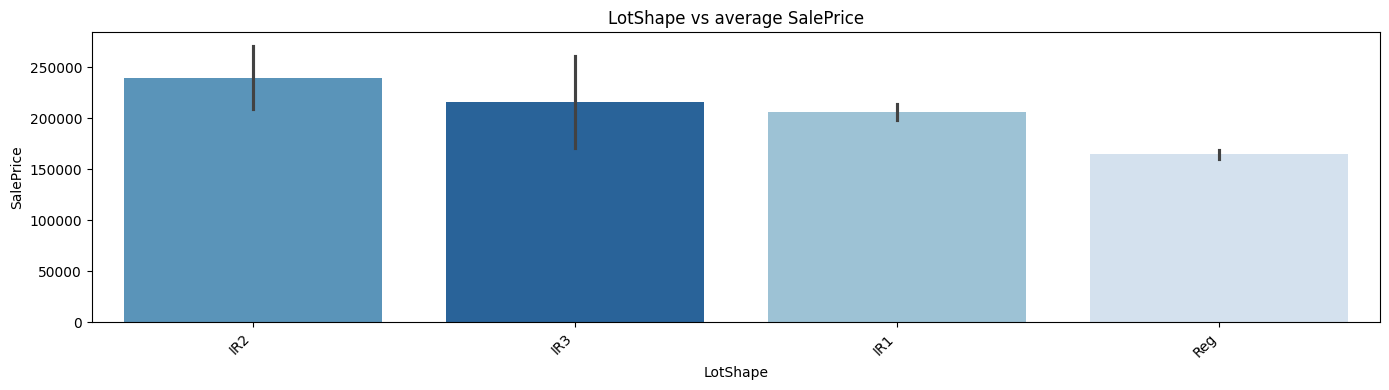

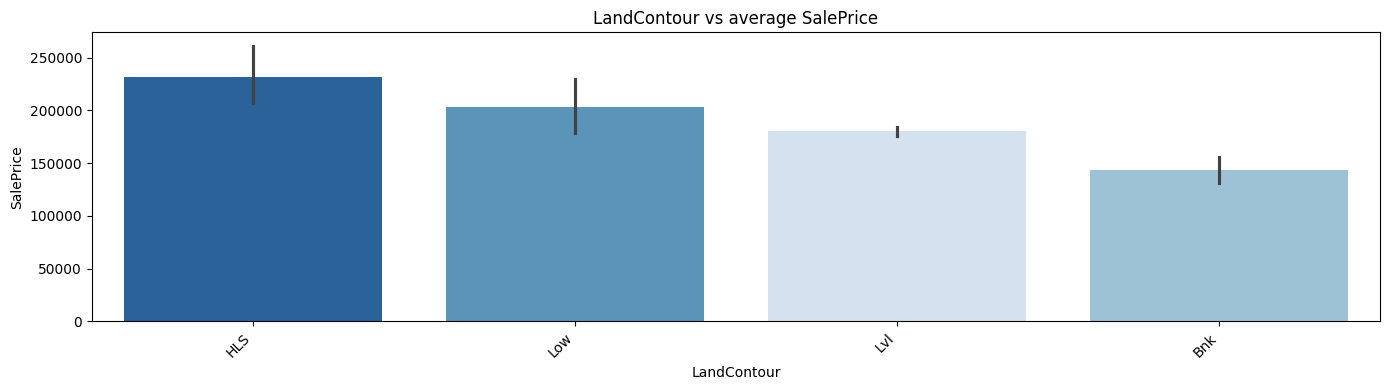

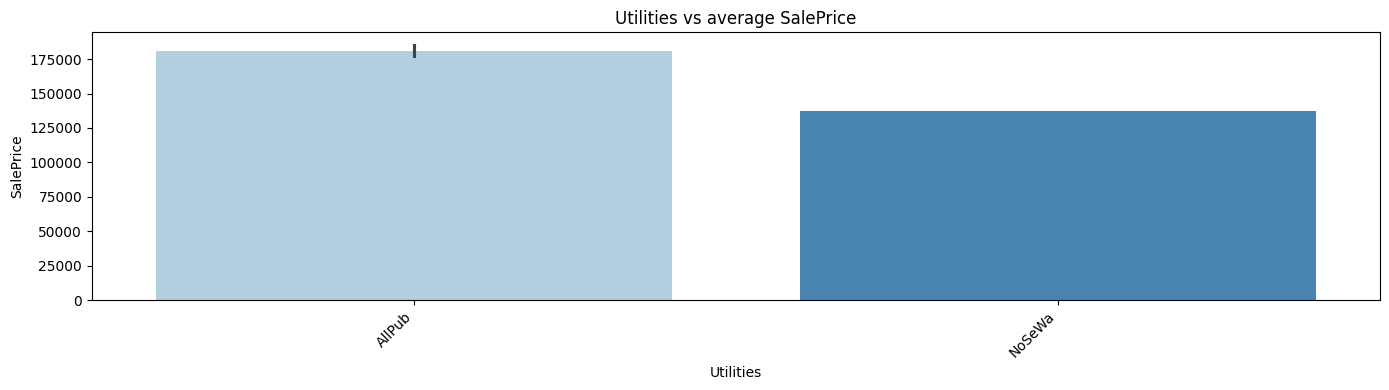

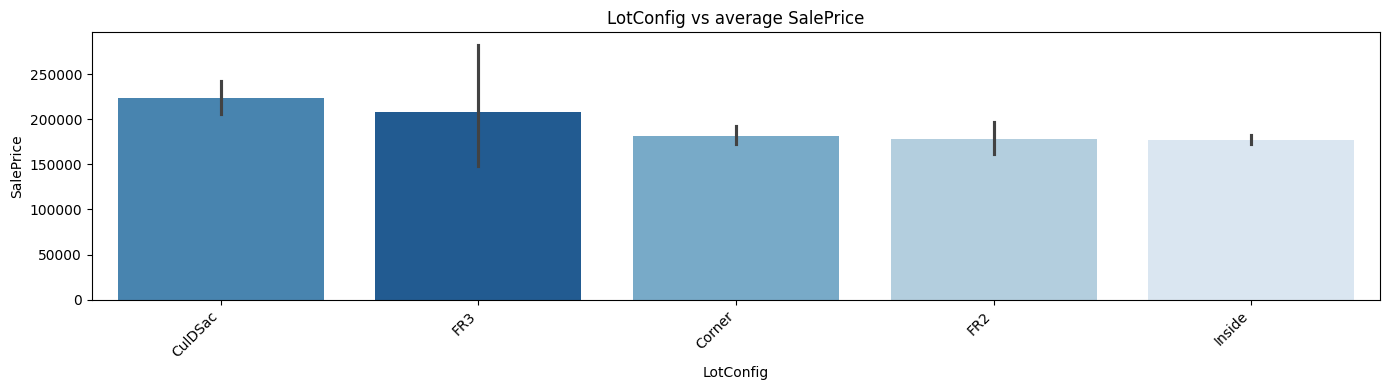

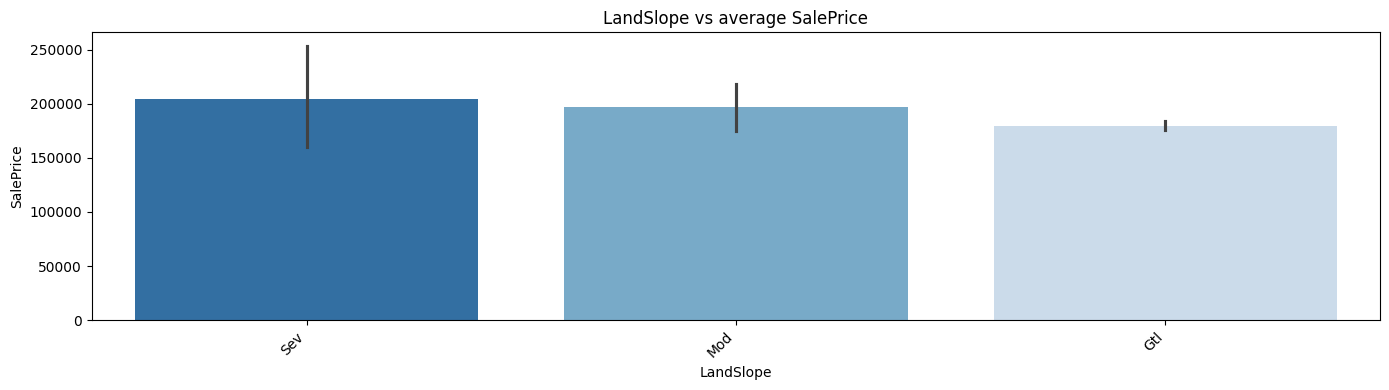

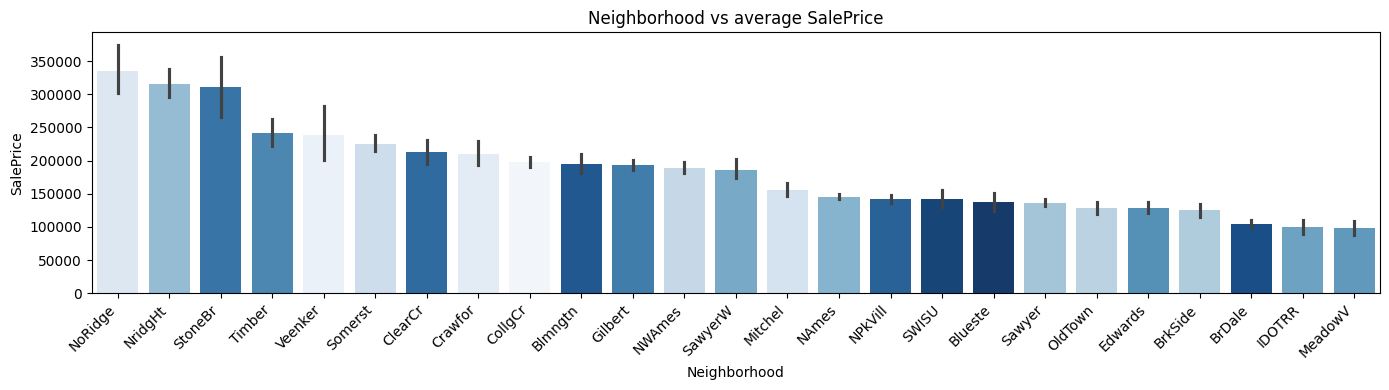

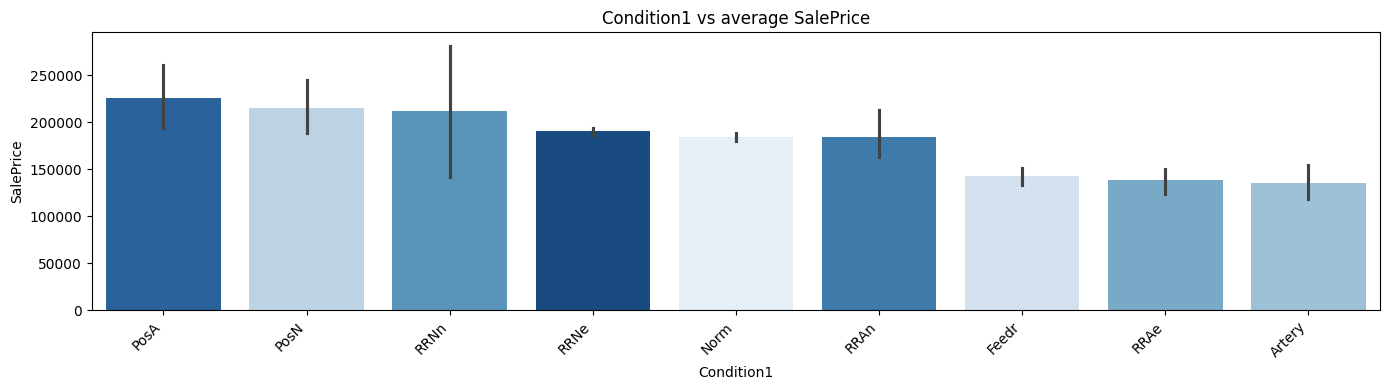

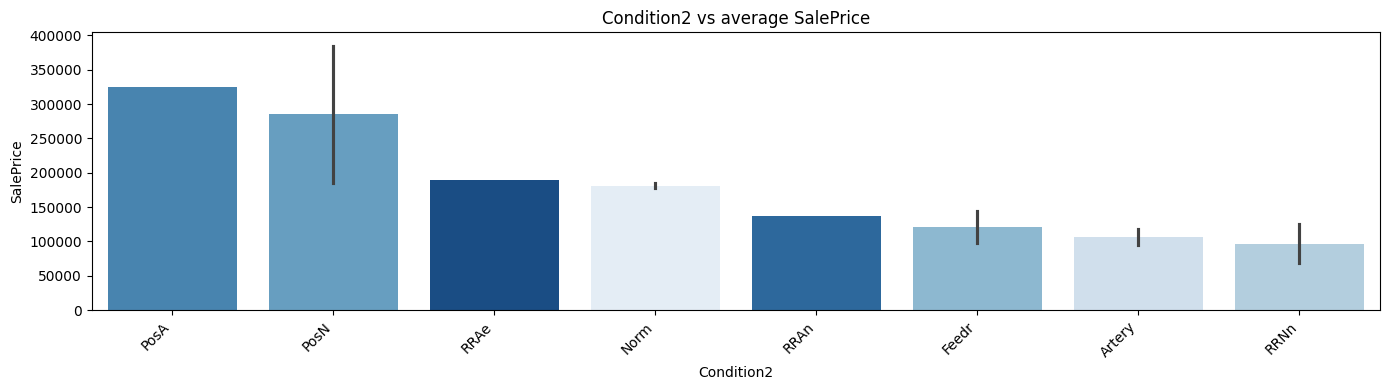

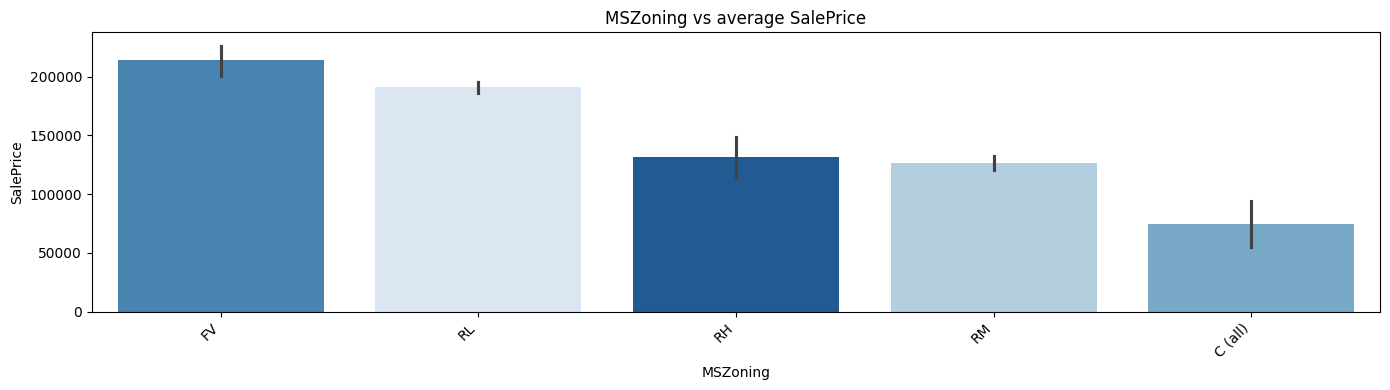

In [19]:
cat_feats = [f for f in land_features if f not in num_feats]
for col in cat_feats:
    plt.figure(figsize=(14, 4))
    order = land_data.groupby(col)['SalePrice'].mean().sort_values(ascending=False).index
    sns.barplot(x=col, y='SalePrice', data=land_data, order=order, palette='Blues', hue=col, legend=False)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{col} vs average SalePrice')
    plt.tight_layout()
    plt.show()

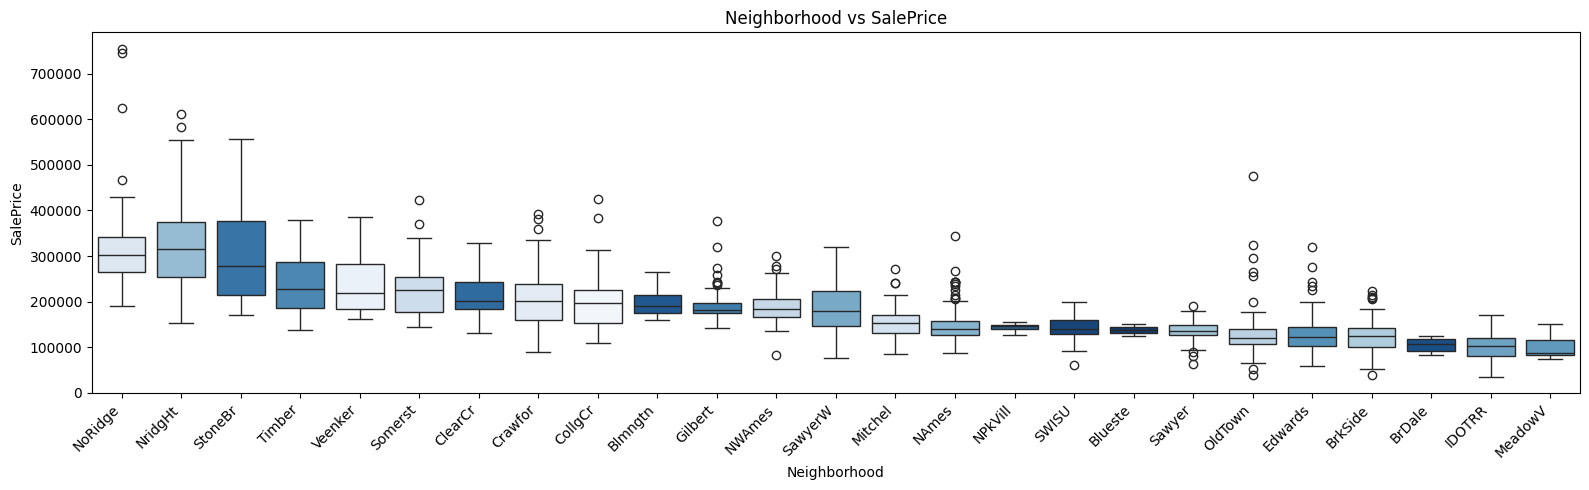

In [20]:
plt.figure(figsize=(16, 5))
order = land_data.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False).index
sns.boxplot(x='Neighborhood', y='SalePrice', data=land_data, order=order, palette='Blues', hue='Neighborhood', legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Neighborhood vs SalePrice')
plt.tight_layout()
plt.show()

In [21]:
for cat_f in cat_feats:
    land_data[f'{cat_f}_num'] = pd.Categorical(land_data[cat_f]).codes

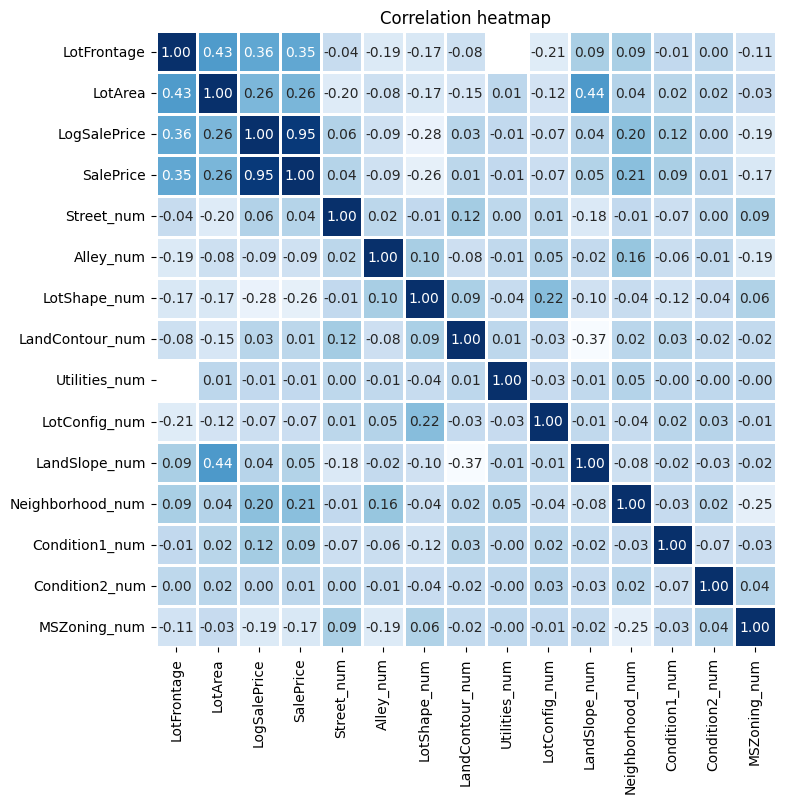

In [22]:
make_heatmap(land_data, figsize=(8,8))

In [23]:
del land_data

##### Характеристика дома

In [24]:
structure_features = ['MSSubClass', 'BldgType', 'HouseStyle']
structure_data = data[structure_features + ['LogSalePrice', 'SalePrice']].copy()

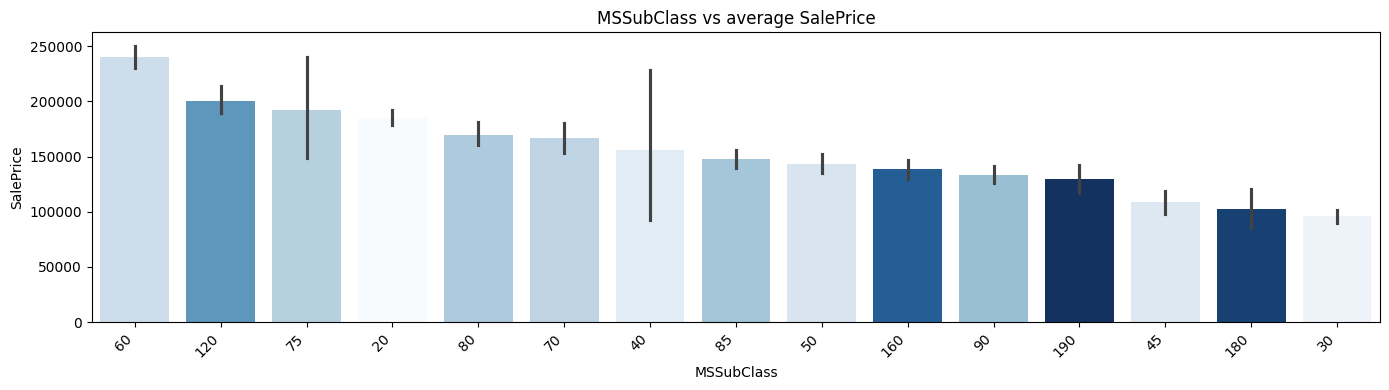

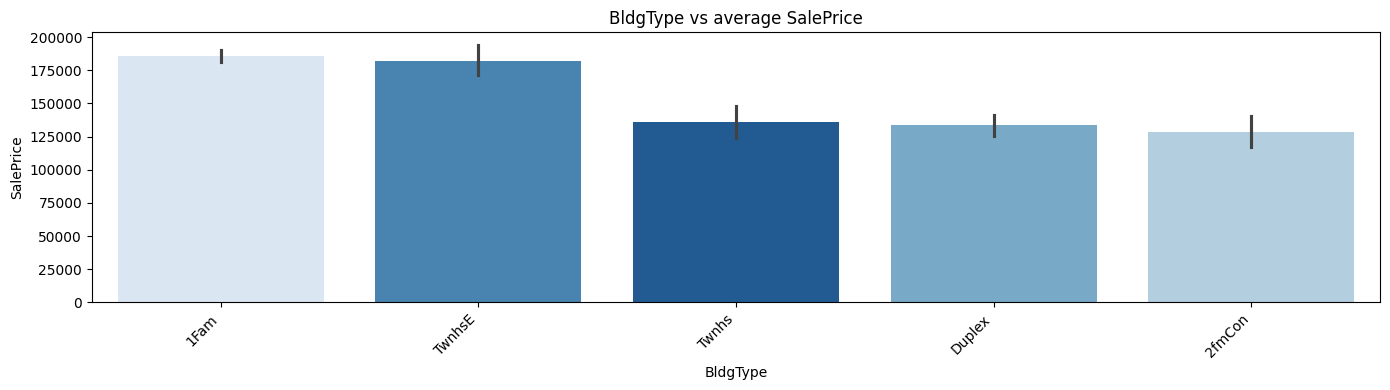

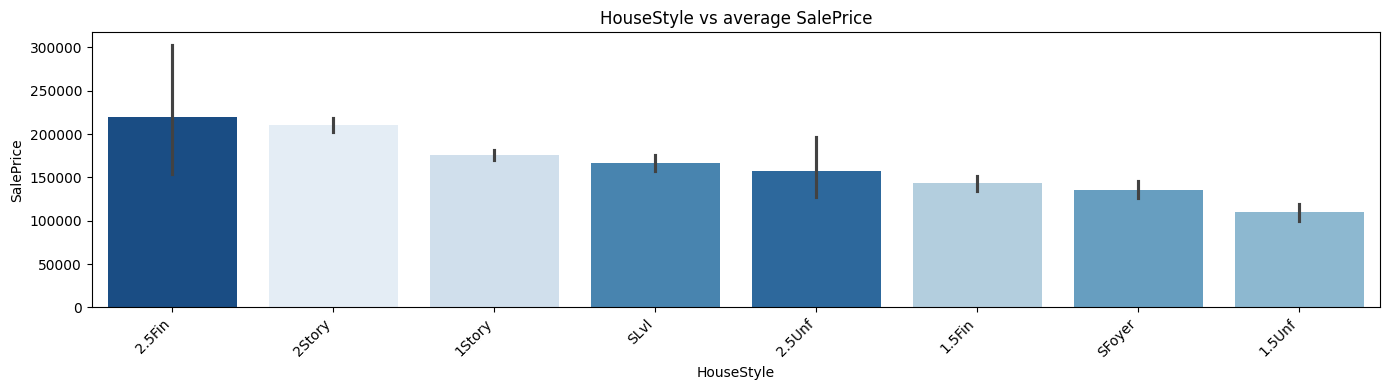

In [25]:
for col in structure_features:
    plt.figure(figsize=(14, 4))
    order = structure_data.groupby(col)['SalePrice'].mean().sort_values(ascending=False).index
    sns.barplot(x=col, y='SalePrice', data=structure_data, order=order, palette='Blues', hue=col, legend=False)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{col} vs average SalePrice')
    plt.tight_layout()
    plt.show()

In [26]:
structure_data['BldgType_num'] = pd.Categorical(structure_data['BldgType']).codes
structure_data['HouseStyle_num'] = pd.Categorical(structure_data['HouseStyle']).codes

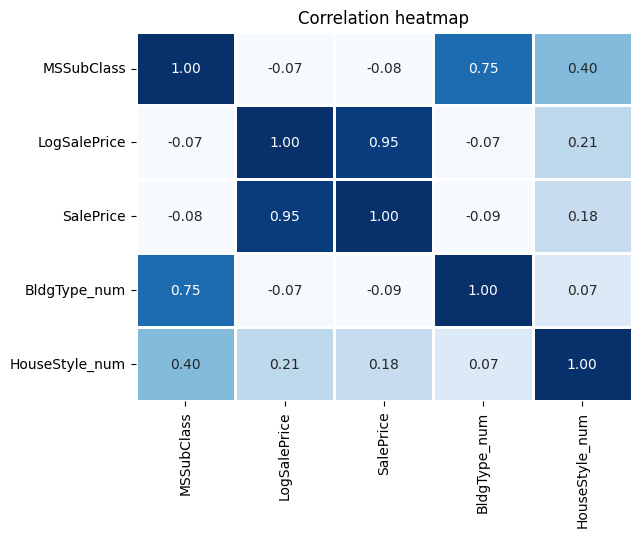

In [27]:
make_heatmap(structure_data)

In [28]:
del structure_data

##### Экстерьер дома

In [29]:
exterior_features = [
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond'
]
exterior_data = data[exterior_features + ['LogSalePrice', 'SalePrice']].copy()

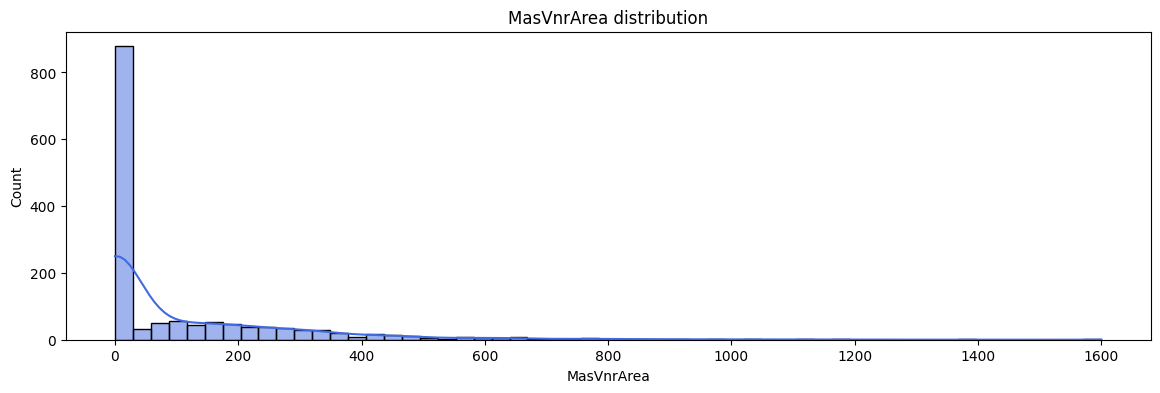

In [30]:
plt.figure(figsize=(14, 4))
sns.histplot(exterior_data['MasVnrArea'], kde=True, color='royalblue')
plt.title('MasVnrArea distribution')
plt.show()

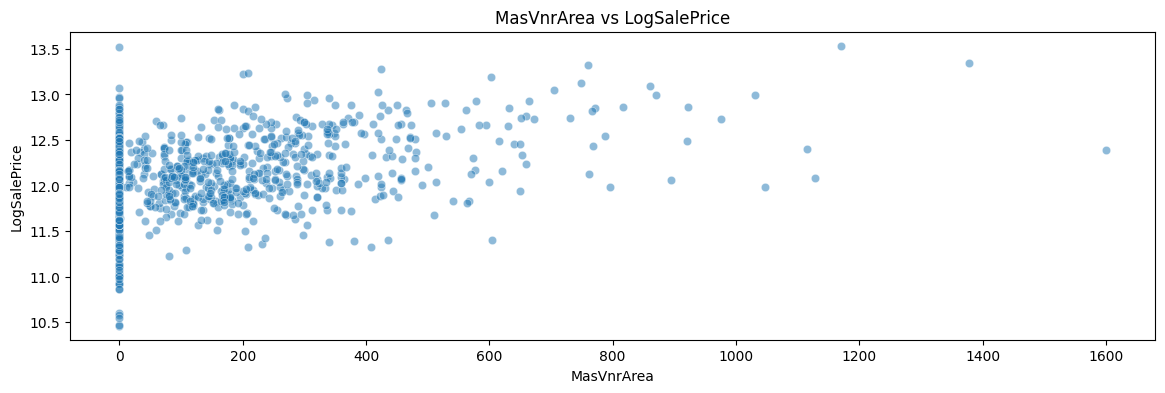

In [31]:
plt.figure(figsize=(14, 4))
sns.scatterplot(x='MasVnrArea', y='LogSalePrice', data=exterior_data, alpha=0.5)
plt.title('MasVnrArea vs LogSalePrice')
plt.show()

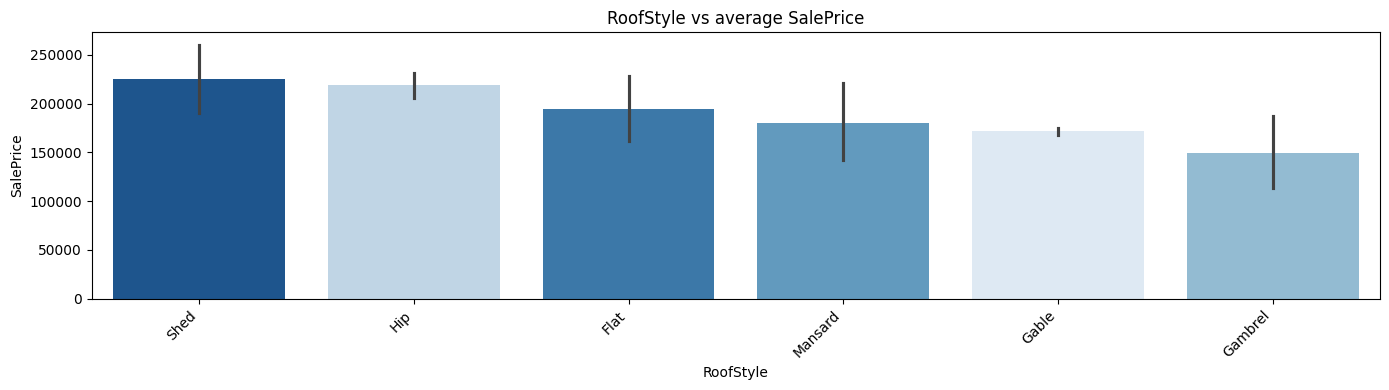

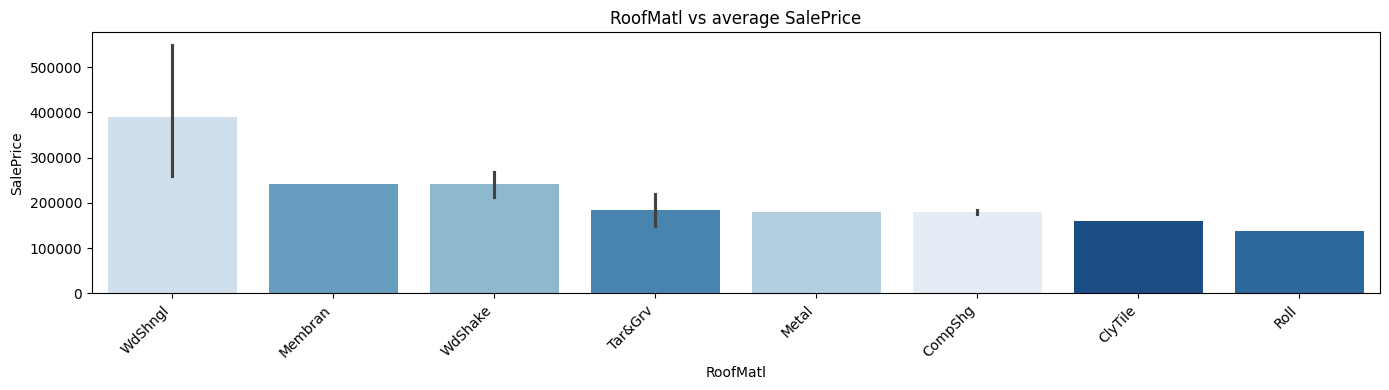

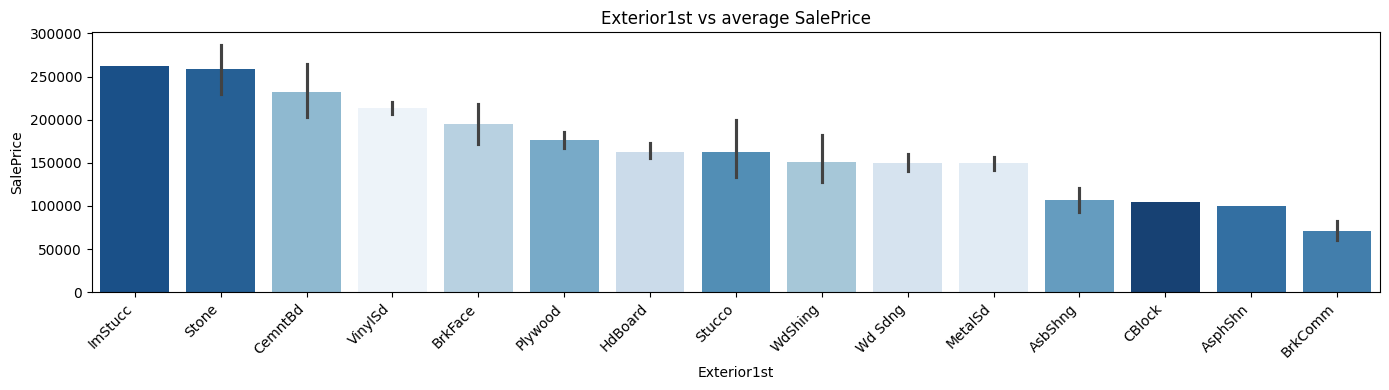

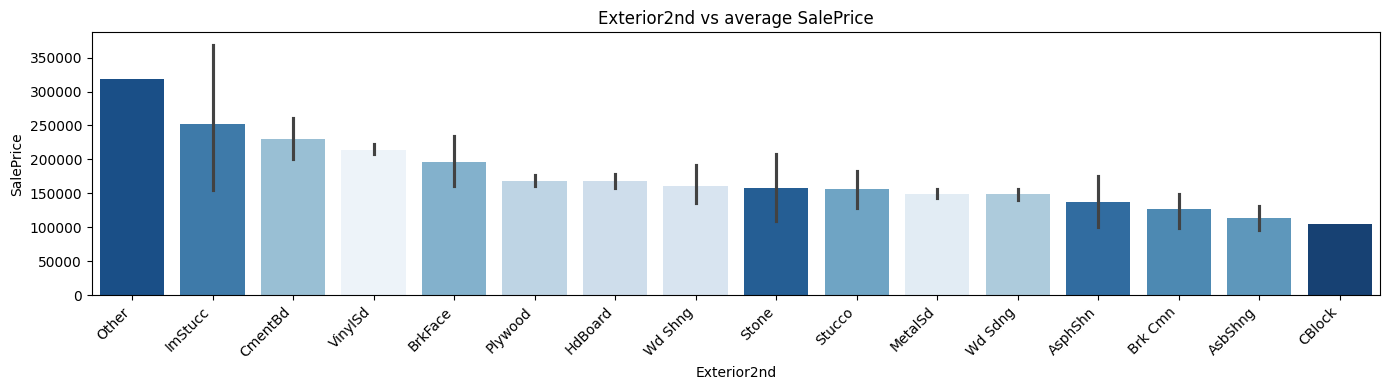

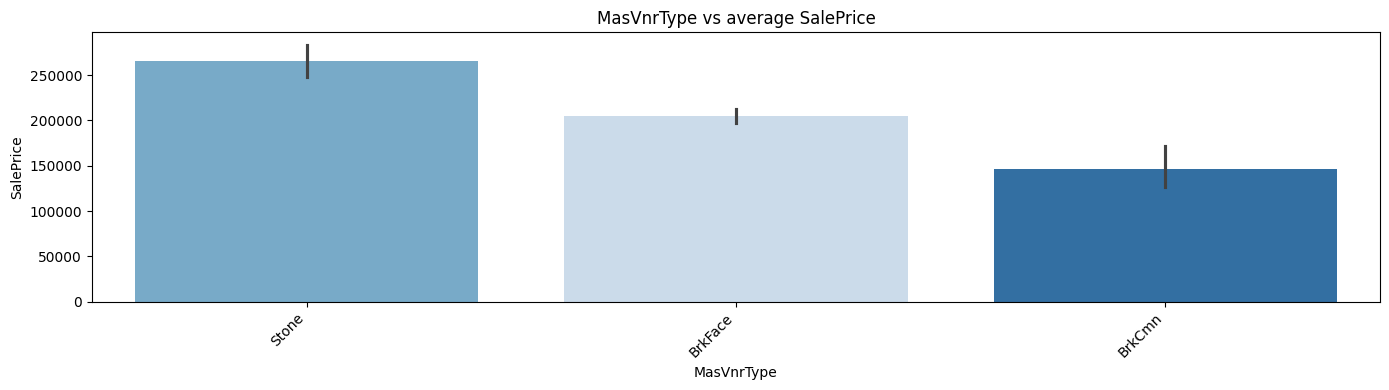

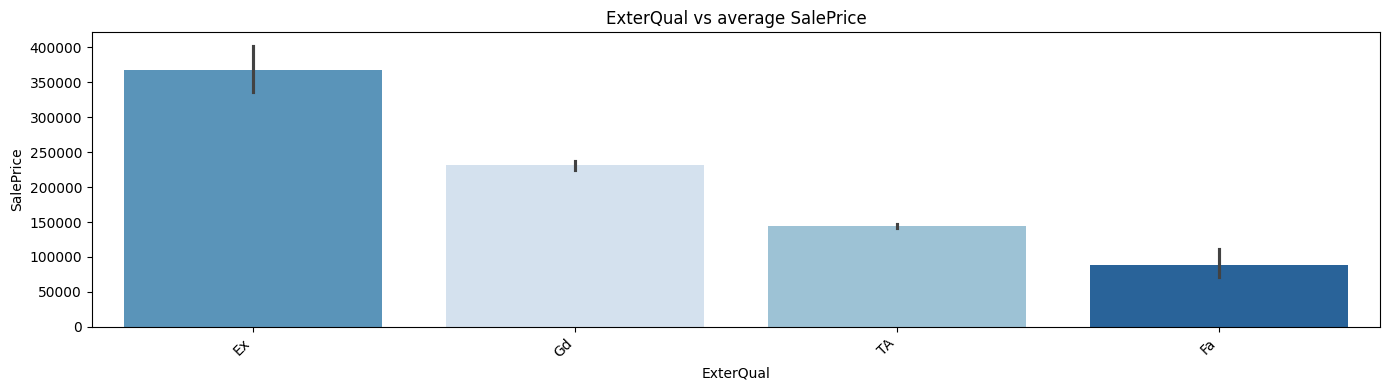

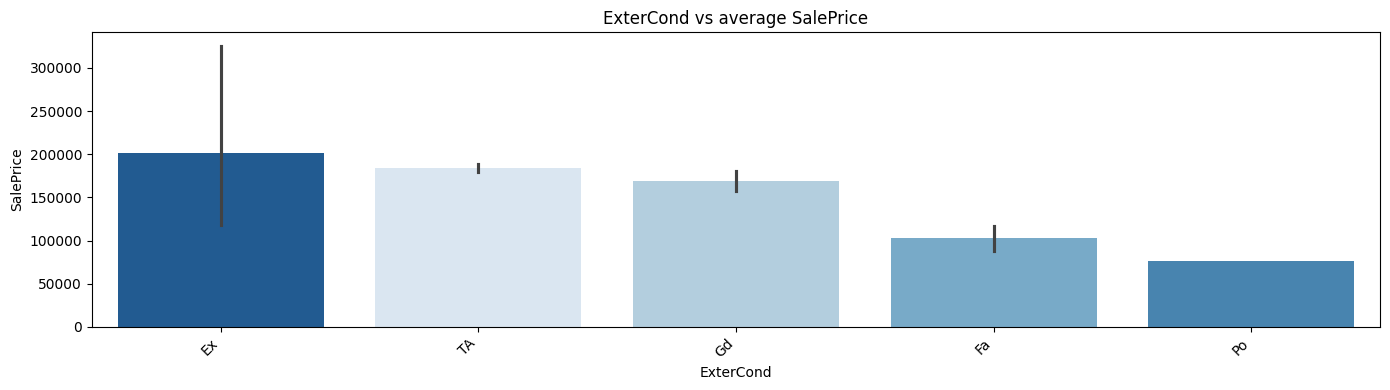

In [32]:
cat_feats = [f for f in exterior_features if f != 'MasVnrArea']
for col in cat_feats:
    plt.figure(figsize=(14, 4))
    order = exterior_data.groupby(col)['SalePrice'].mean().sort_values(ascending=False).index
    sns.barplot(x=col, y='SalePrice', data=exterior_data, order=order, palette='Blues', hue=col, legend=False)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{col} vs average SalePrice')
    plt.tight_layout()
    plt.show()

In [33]:
for cat_f in cat_feats:
    exterior_data[f'{cat_f}_num'] = pd.Categorical(exterior_data[cat_f]).codes

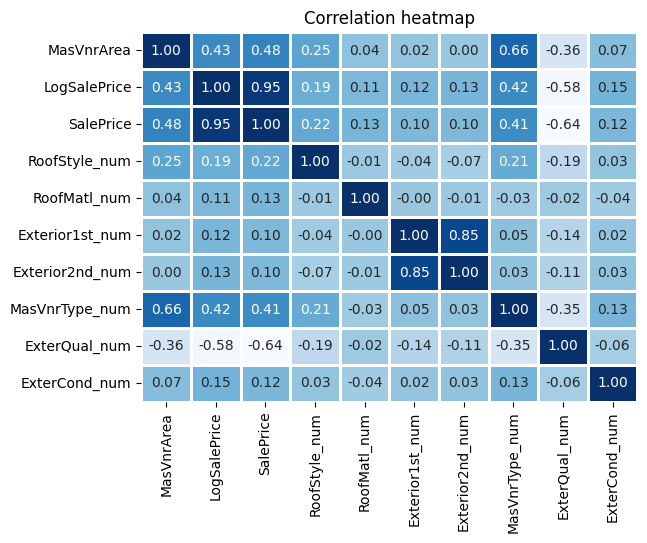

In [34]:
make_heatmap(exterior_data)

In [35]:
del exterior_data

##### Площади и возраста

In [36]:
size_features = [
    'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF',
    'LowQualFinSF', 'GrLivArea', 'TotalBsmtSF'
]
size_data = data[size_features + ['LogSalePrice', 'SalePrice']].copy()

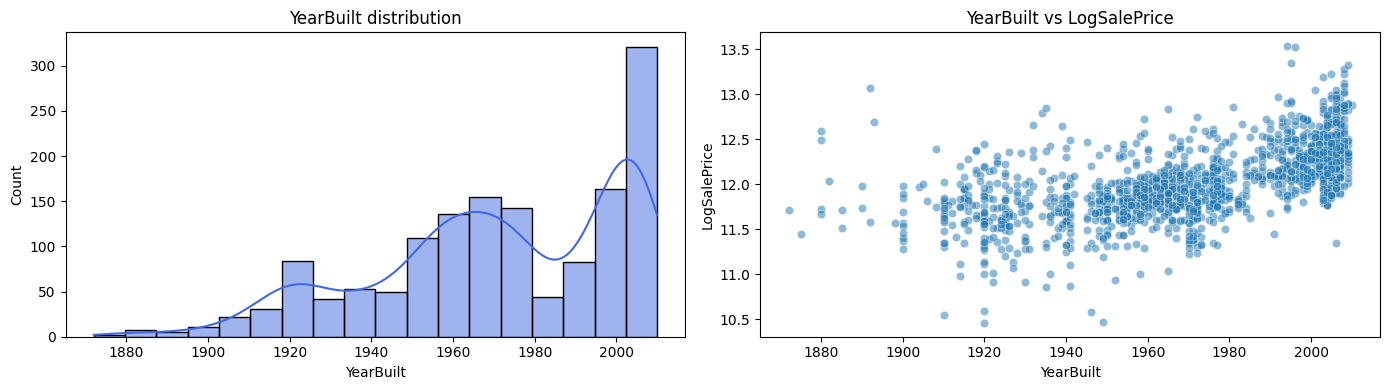

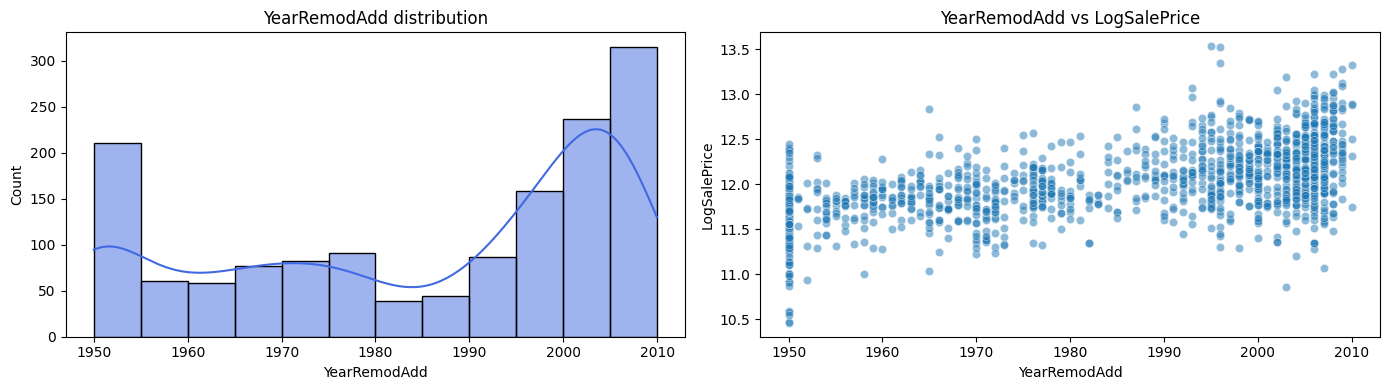

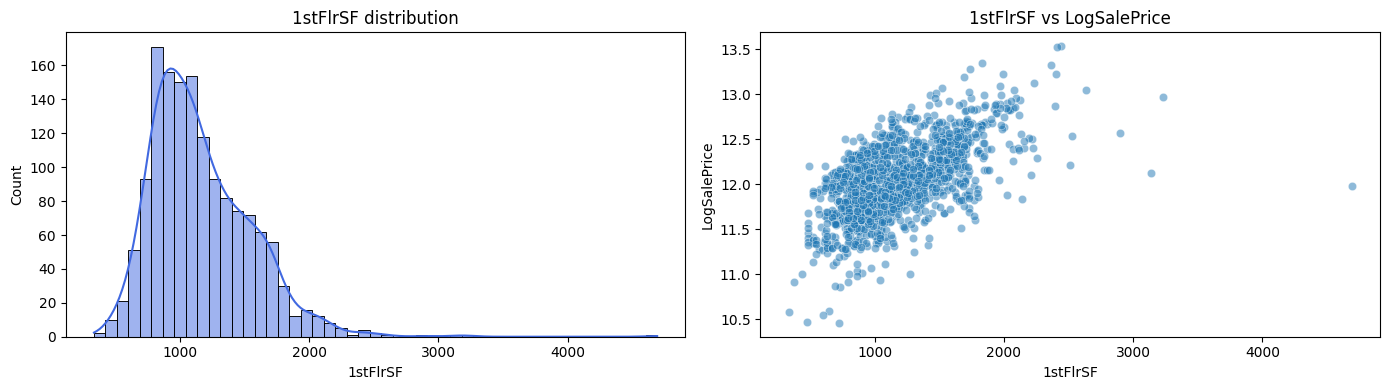

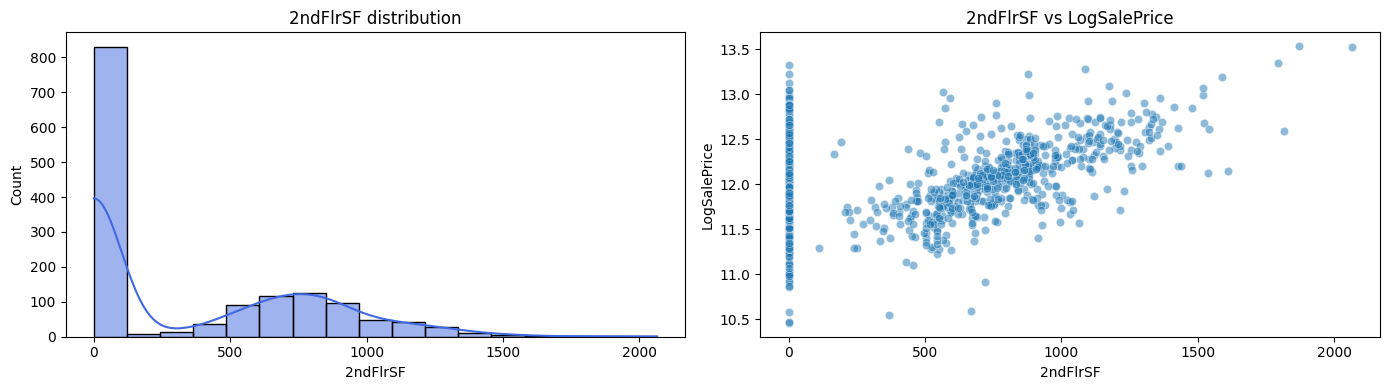

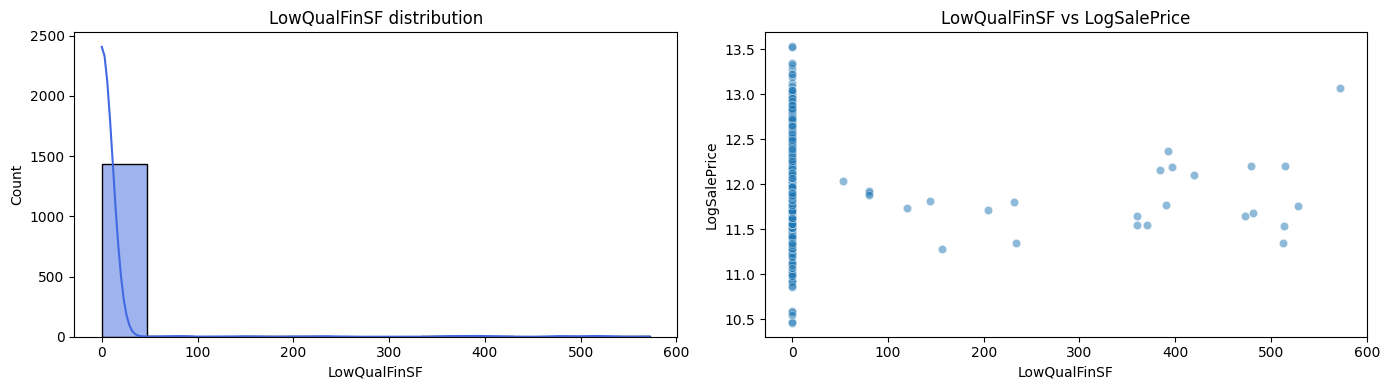

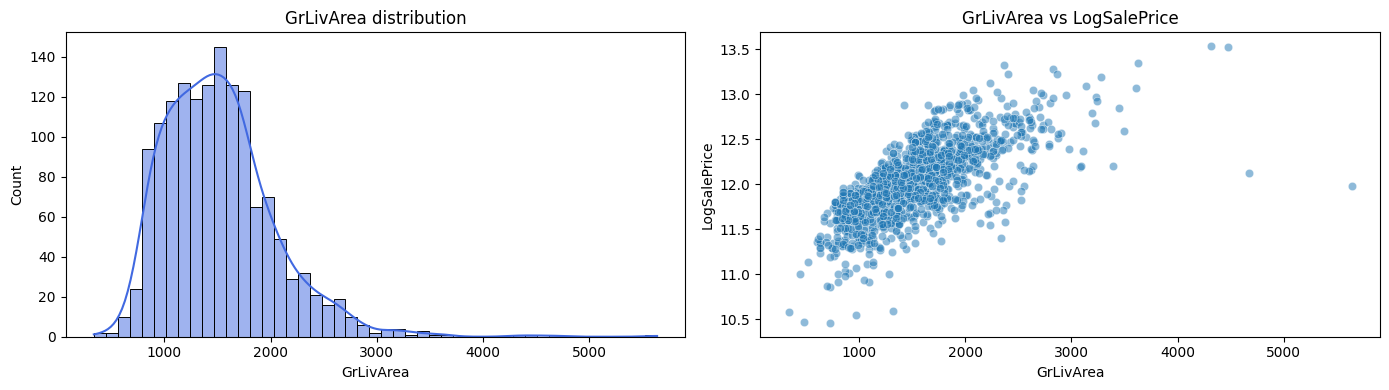

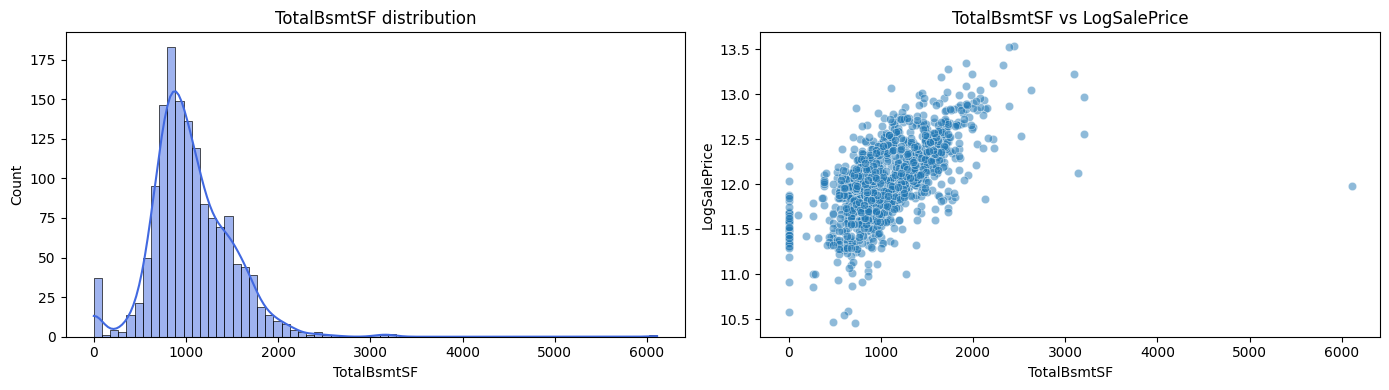

In [37]:
for col in size_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    sns.histplot(size_data[col], kde=True, ax=axes[0], color='royalblue')
    axes[0].set_title(f'{col} distribution')
    sns.scatterplot(x=col, y='LogSalePrice', data=size_data, alpha=0.5, ax=axes[1])
    axes[1].set_title(f'{col} vs LogSalePrice')
    plt.tight_layout()
    plt.show()

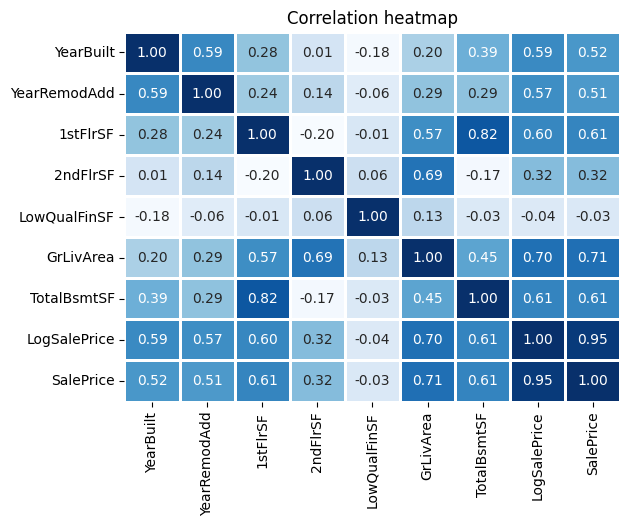

In [38]:
make_heatmap(size_data)

In [39]:
del size_data

##### Посмотрим на подвалы

In [40]:
basement_features = [
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF'
]
basement_data = data[basement_features + ['LogSalePrice', 'SalePrice']].copy()

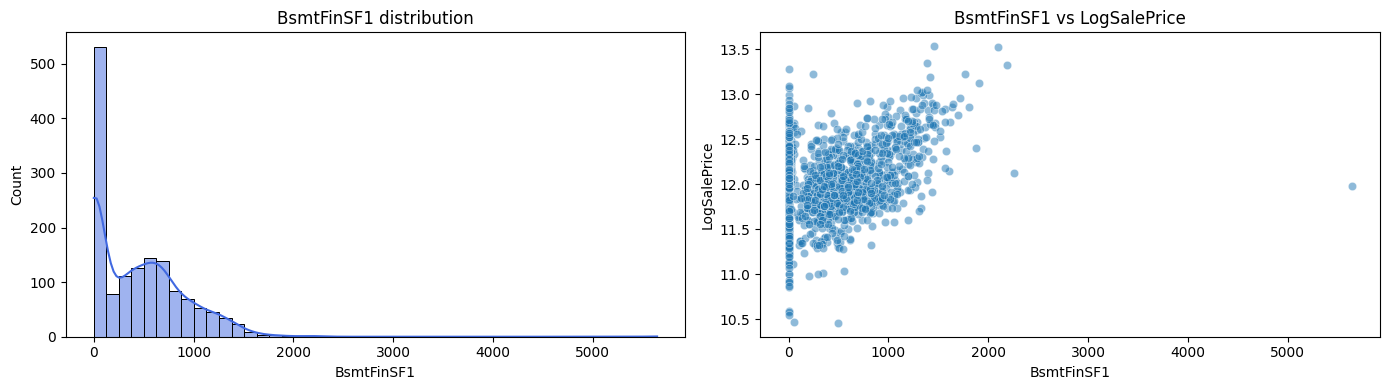

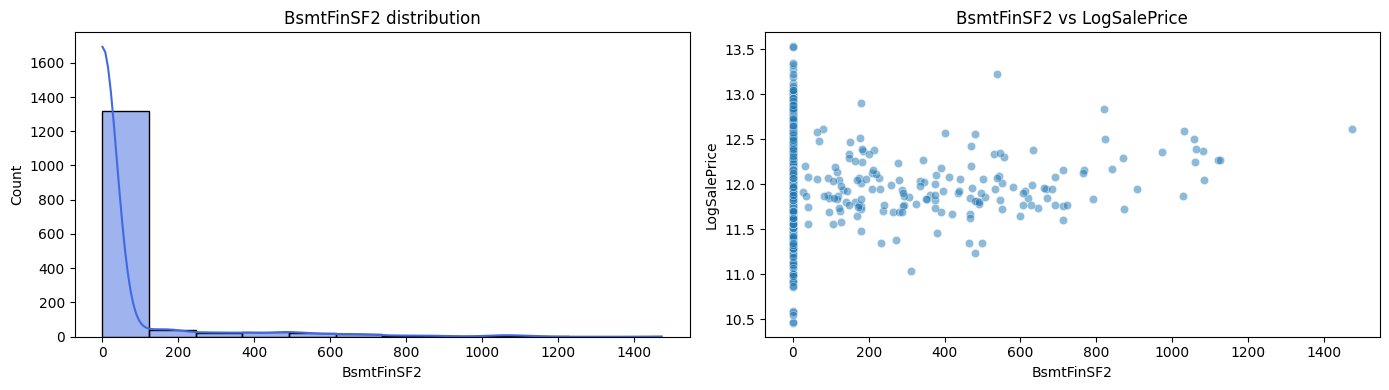

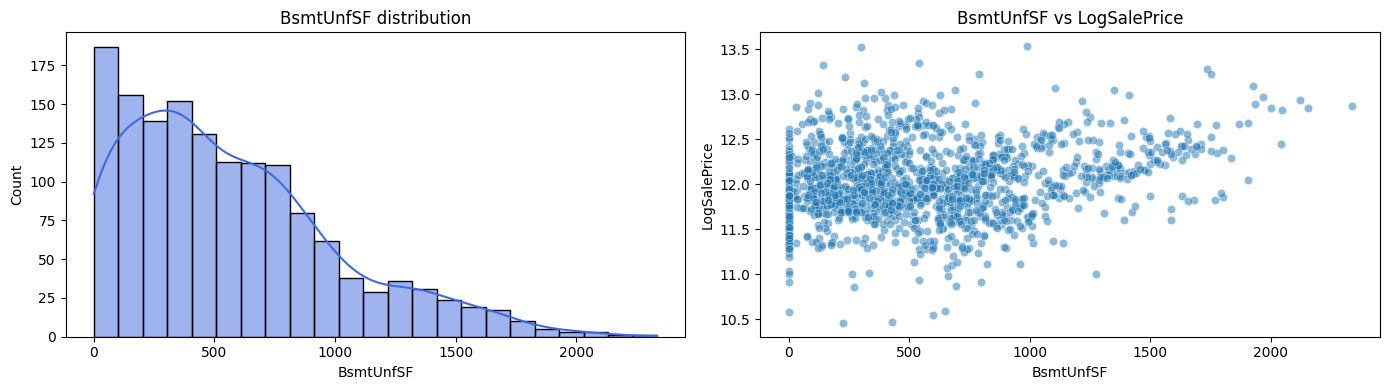

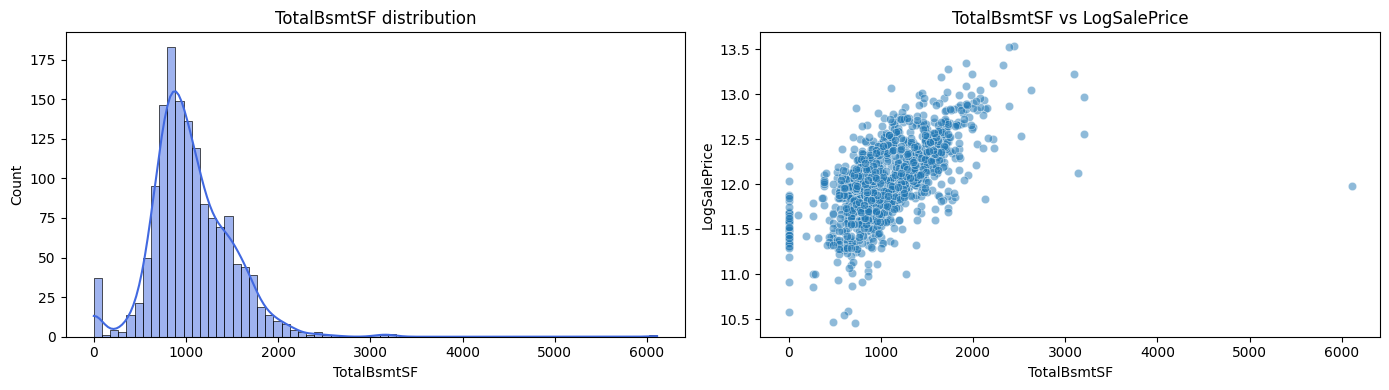

In [41]:
num_feats = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
for col in num_feats:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    sns.histplot(basement_data[col], kde=True, ax=axes[0], color='royalblue')
    axes[0].set_title(f'{col} distribution')
    sns.scatterplot(x=col, y='LogSalePrice', data=basement_data, alpha=0.5, ax=axes[1])
    axes[1].set_title(f'{col} vs LogSalePrice')
    plt.tight_layout()
    plt.show()

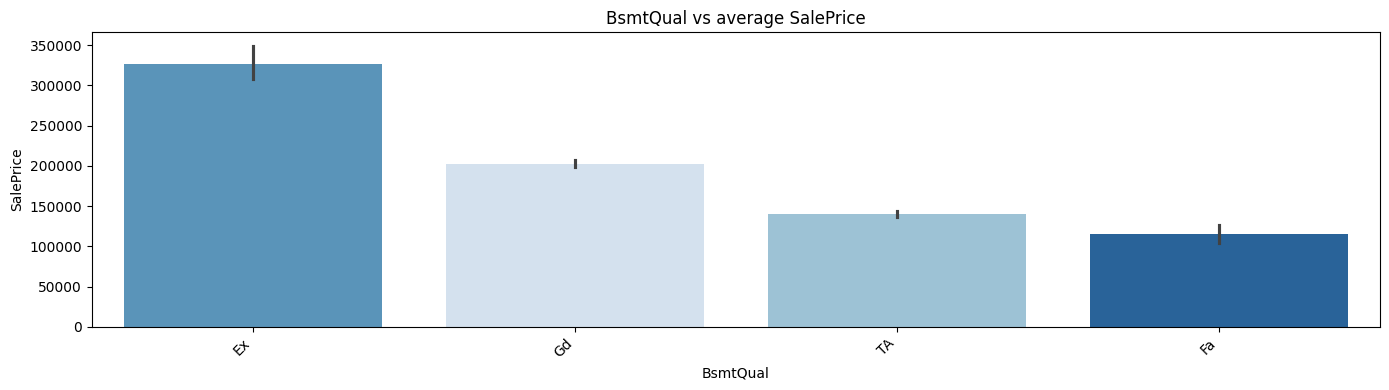

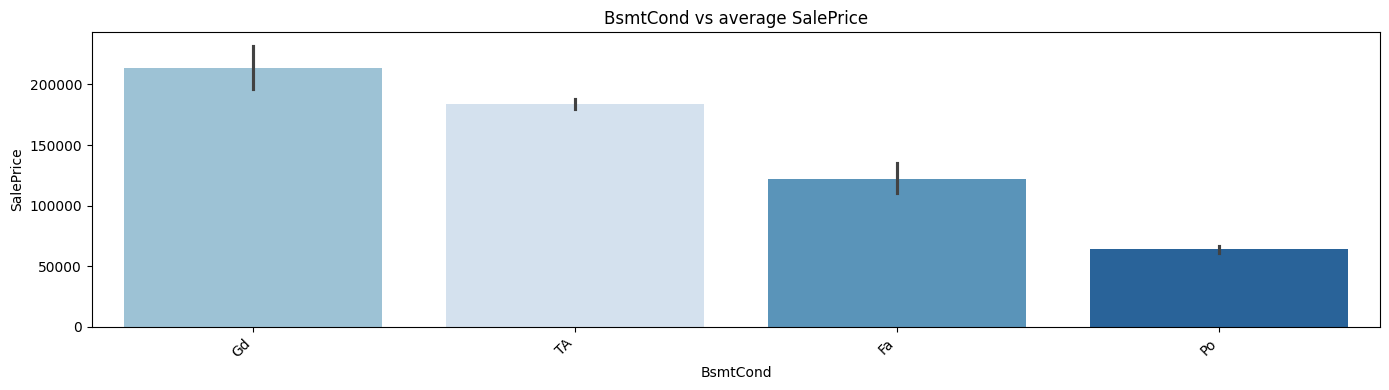

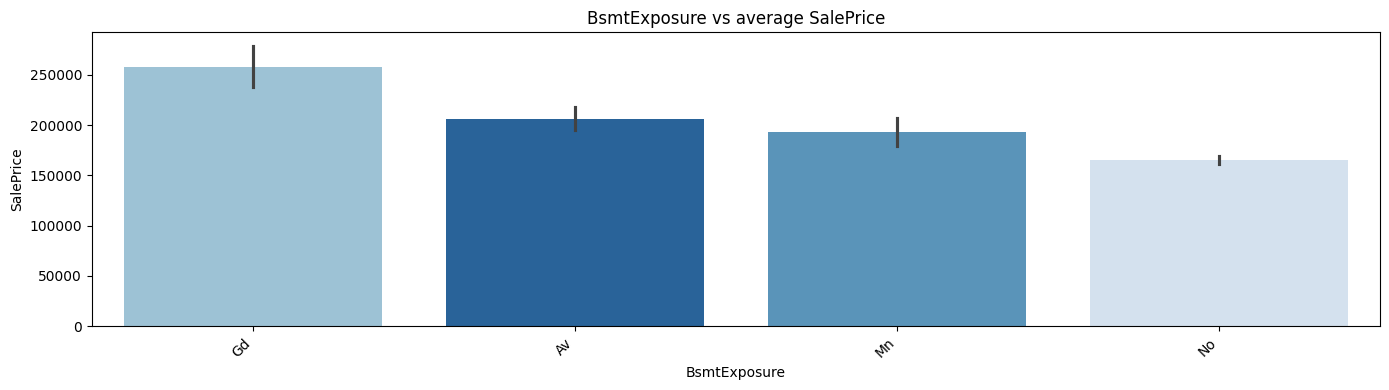

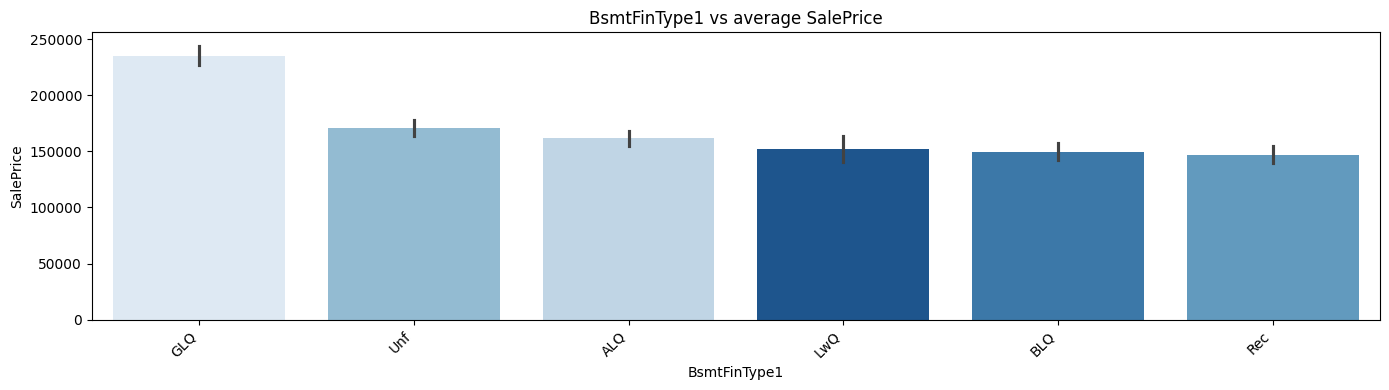

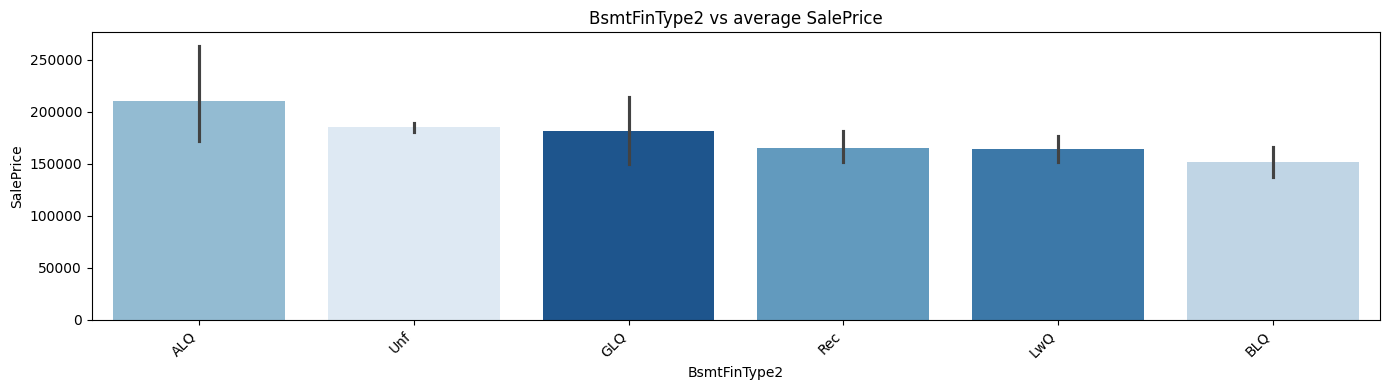

In [42]:
cat_feats = [f for f in basement_features if f not in num_feats]
for col in cat_feats:
    plt.figure(figsize=(14, 4))
    order = basement_data.groupby(col)['SalePrice'].mean().sort_values(ascending=False).index
    sns.barplot(x=col, y='SalePrice', data=basement_data, order=order, palette='Blues', hue=col, legend=False)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{col} vs average SalePrice')
    plt.tight_layout()
    plt.show()

In [43]:
for cat_f in cat_feats:
    basement_data[f'{cat_f}_num'] = pd.Categorical(basement_data[cat_f]).codes

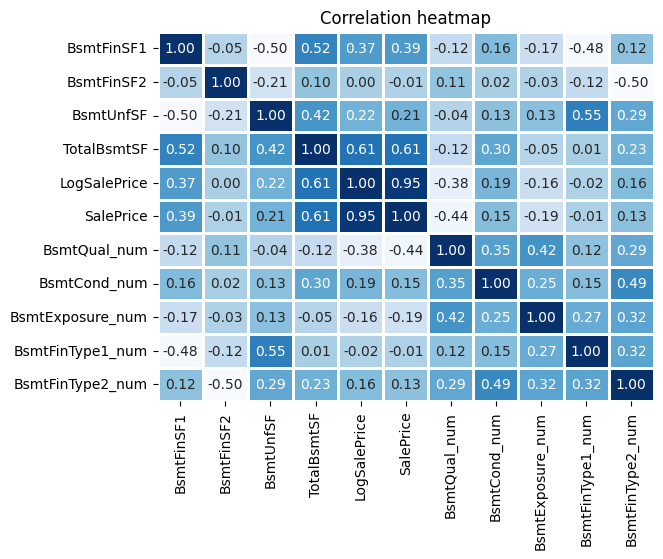

In [44]:
make_heatmap(basement_data)

In [45]:
del basement_data

##### Коммуникации

In [46]:
engineering_features = ['Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'Utilities']
eng_data = data[engineering_features + ['LogSalePrice', 'SalePrice']].copy()

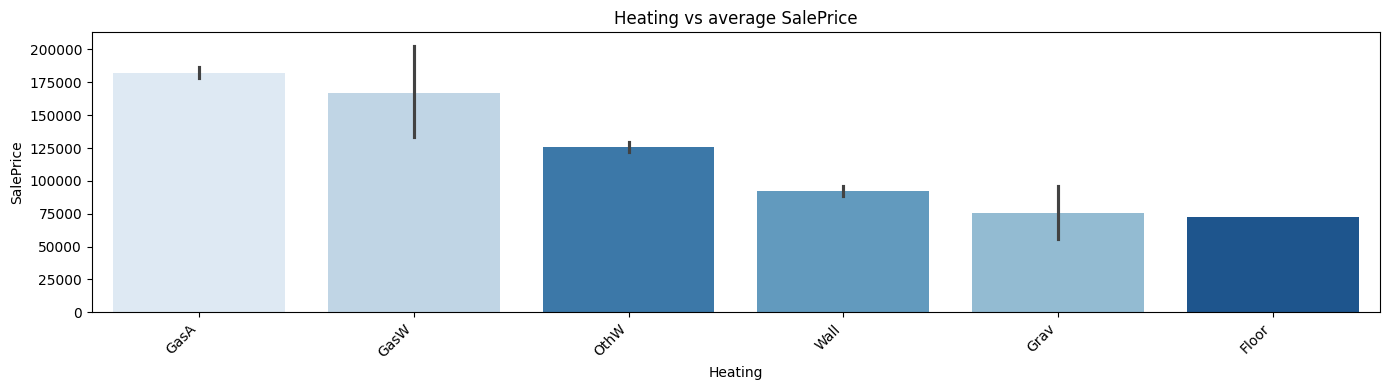

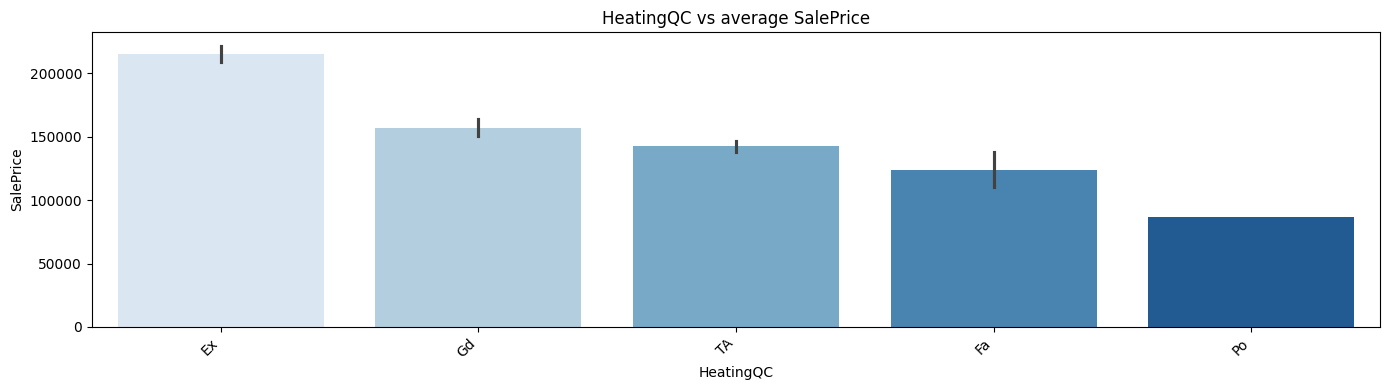

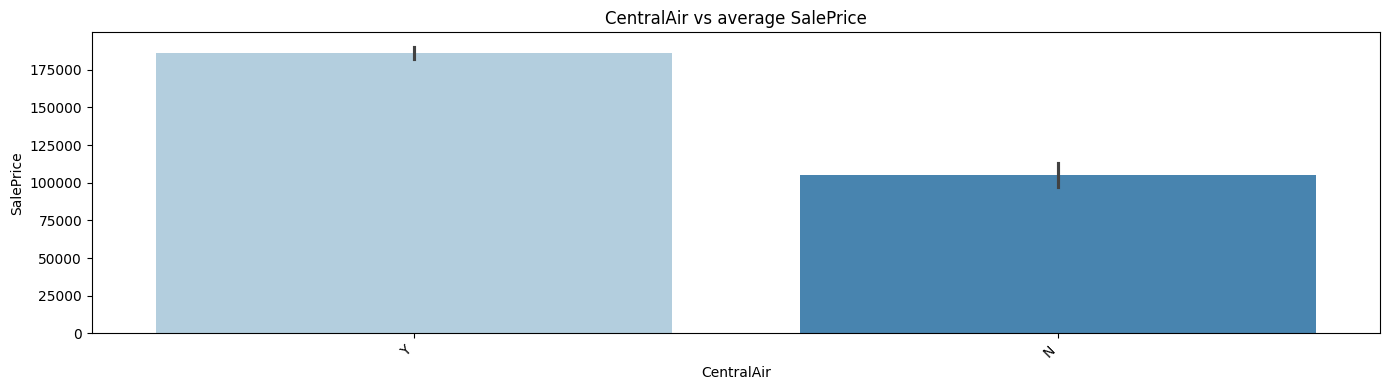

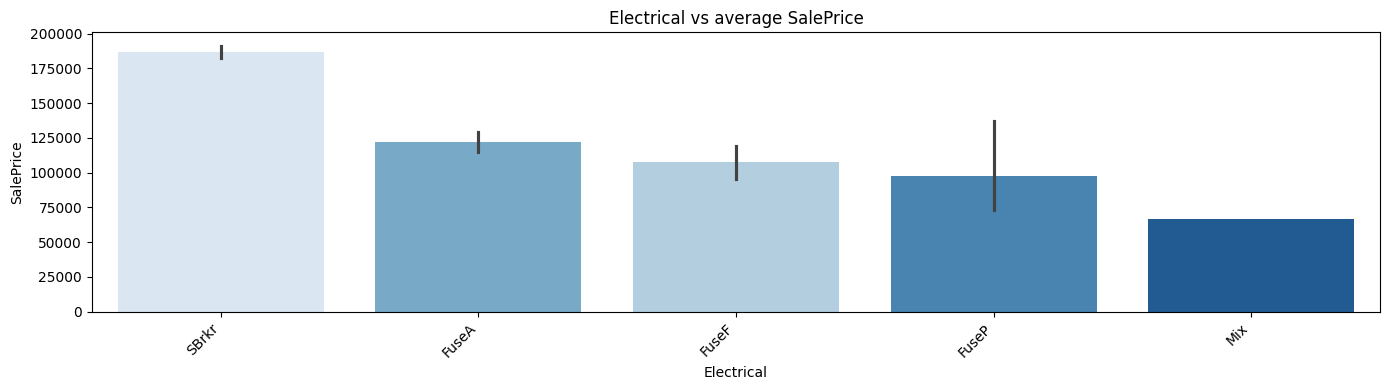

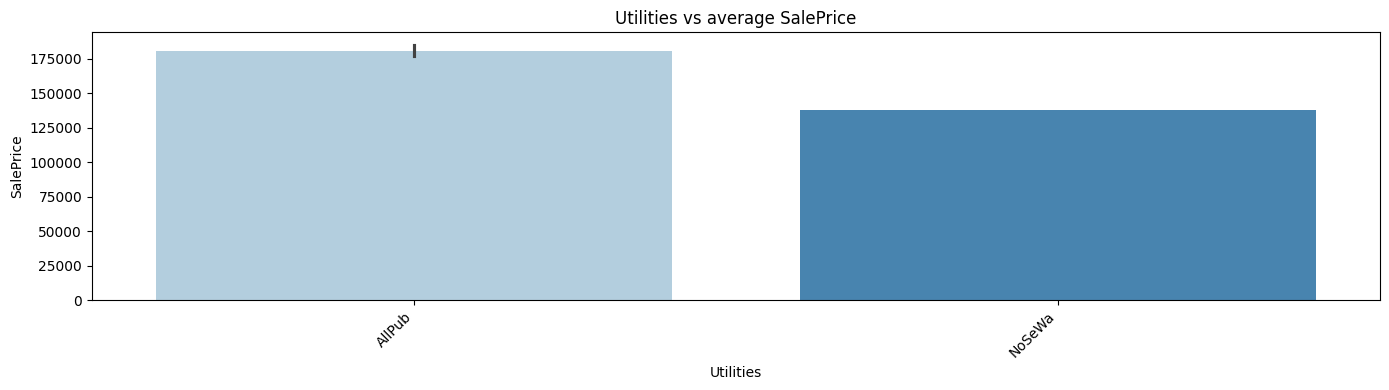

In [47]:
for col in engineering_features:
    plt.figure(figsize=(14, 4))
    order = eng_data.groupby(col)['SalePrice'].mean().sort_values(ascending=False).index
    sns.barplot(x=col, y='SalePrice', data=eng_data, order=order, palette='Blues', hue=col, legend=False)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{col} vs average SalePrice')
    plt.tight_layout()
    plt.show()

In [48]:
for cat_f in engineering_features:
    eng_data[f'{cat_f}_num'] = pd.Categorical(eng_data[cat_f]).codes

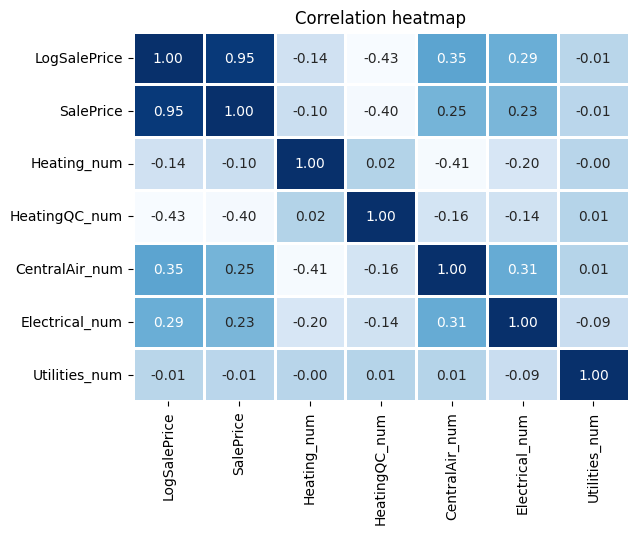

In [49]:
make_heatmap(eng_data)

In [50]:
del eng_data

##### Планировка

In [51]:
layout_features = [
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional'
]
layout_data = data[layout_features + ['LogSalePrice', 'SalePrice']].copy()

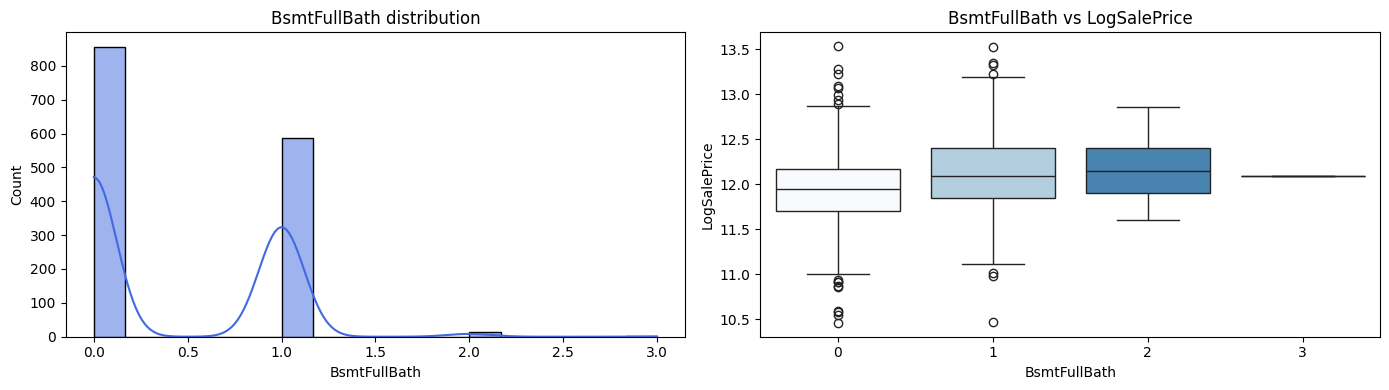

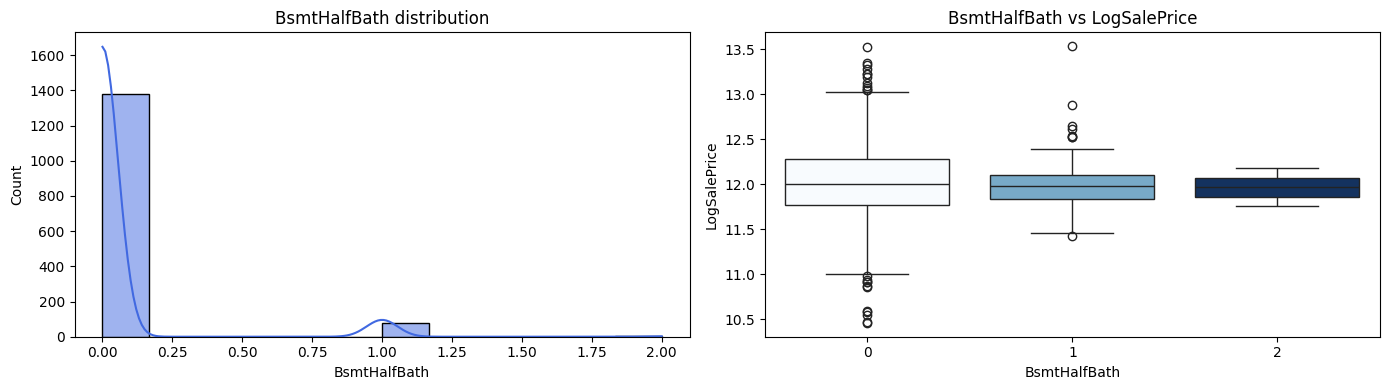

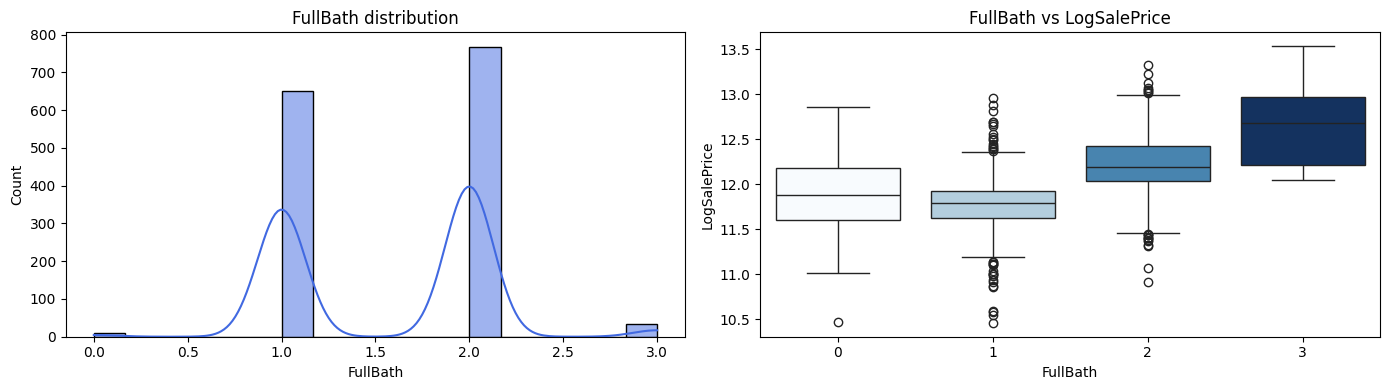

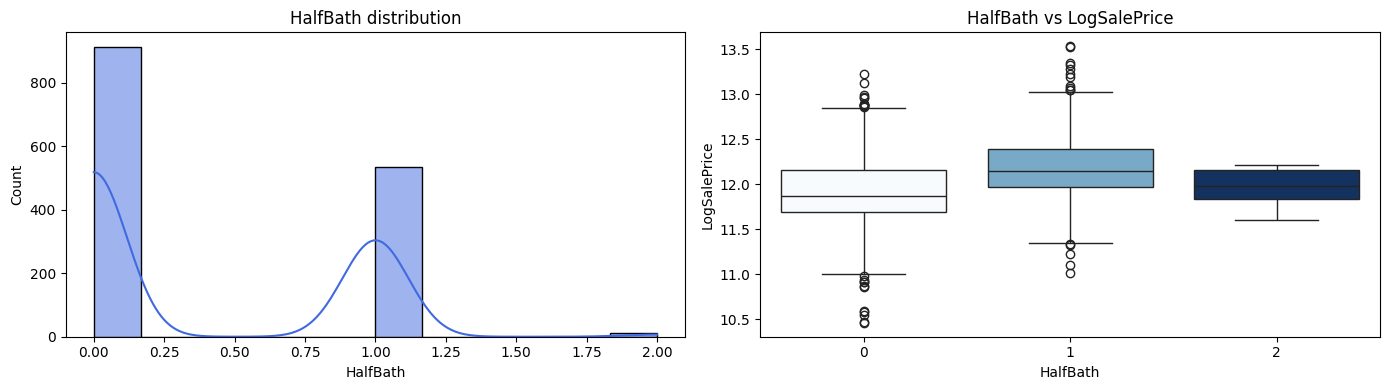

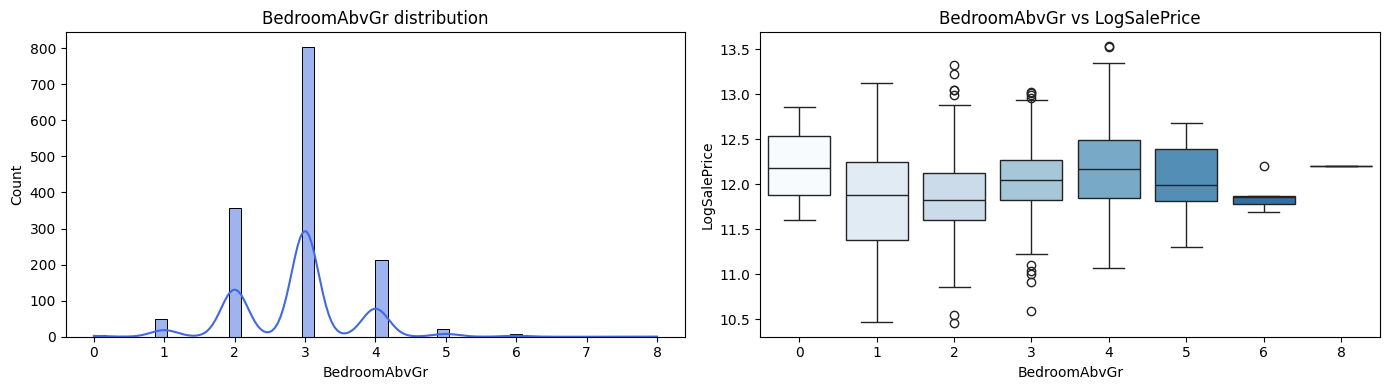

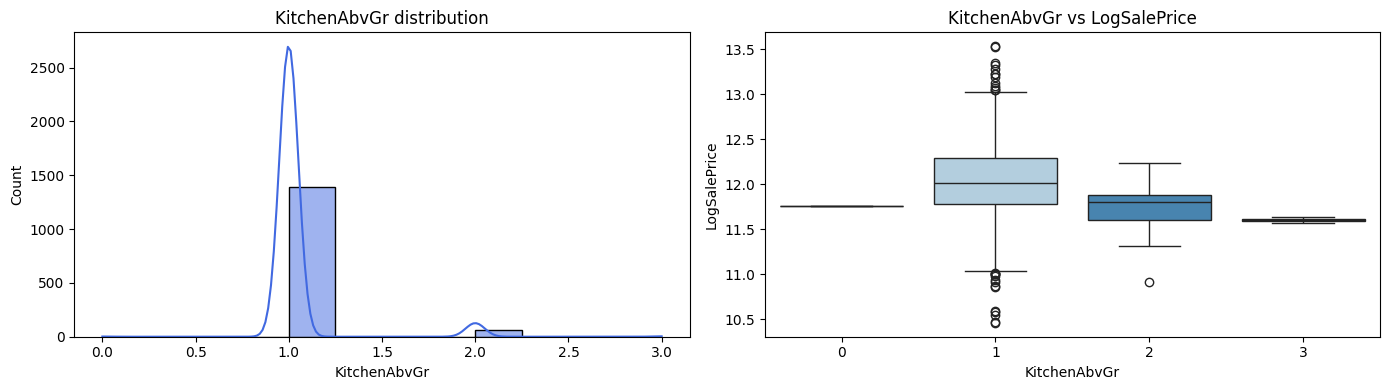

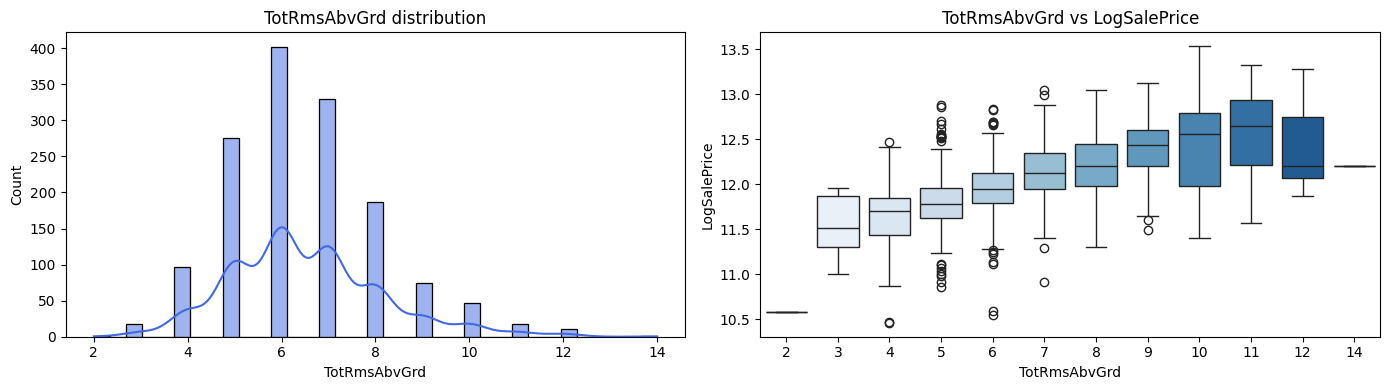

In [52]:
num_feats = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']
for col in num_feats:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    sns.histplot(layout_data[col], kde=True, ax=axes[0], color='royalblue')
    axes[0].set_title(f'{col} distribution')
    sns.boxplot(x=col, y='LogSalePrice', data=layout_data, ax=axes[1], palette='Blues', hue=col, legend=False)
    axes[1].set_title(f'{col} vs LogSalePrice')
    plt.tight_layout()
    plt.show()

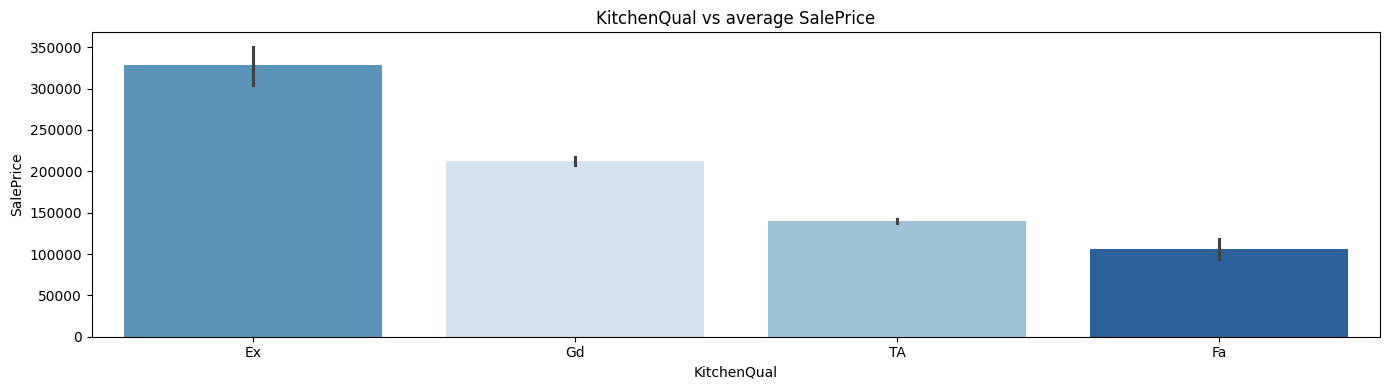

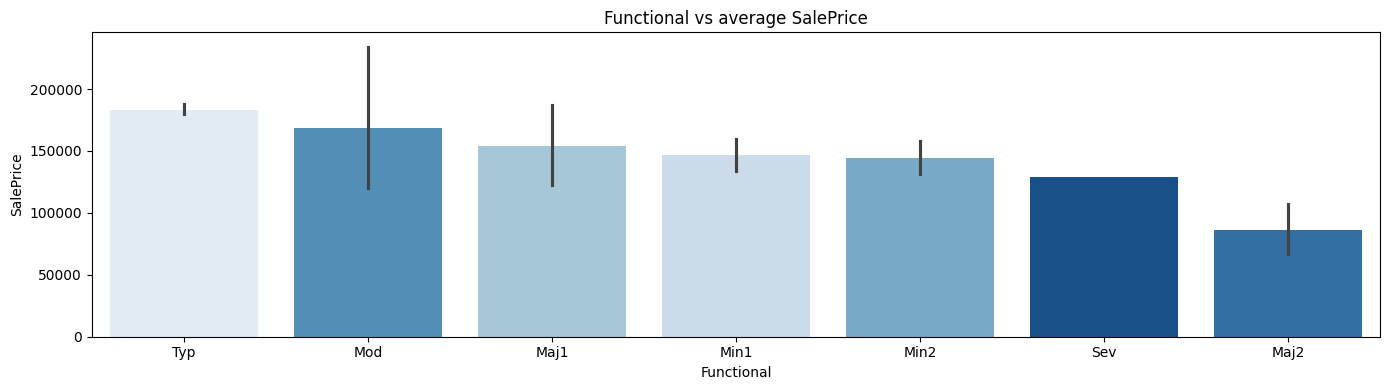

In [53]:
cat_feats = ['KitchenQual', 'Functional']
for col in cat_feats:
    plt.figure(figsize=(14, 4))
    order = layout_data.groupby(col)['SalePrice'].mean().sort_values(ascending=False).index
    sns.barplot(x=col, y='SalePrice', data=layout_data, order=order, palette='Blues', hue=col, legend=False)
    plt.title(f'{col} vs average SalePrice')
    plt.tight_layout()
    plt.show()

In [54]:
for cat_f in cat_feats:
    layout_data[f'{cat_f}_num'] = pd.Categorical(layout_data[cat_f]).codes

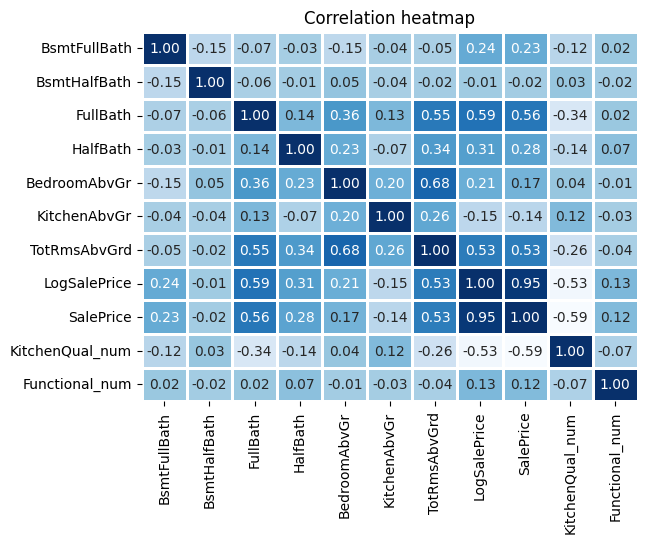

In [55]:
make_heatmap(layout_data)

In [56]:
del layout_data

##### Гаражи, камины и прочее

In [57]:
amenity_features = [
    'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
    'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
    'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'
]
amenity_data = data[amenity_features + ['LogSalePrice', 'SalePrice']].copy()

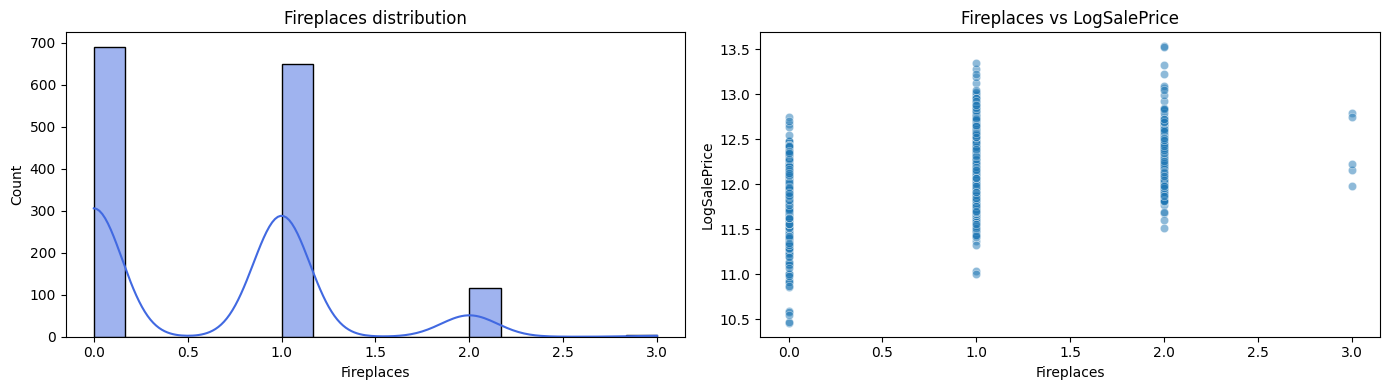

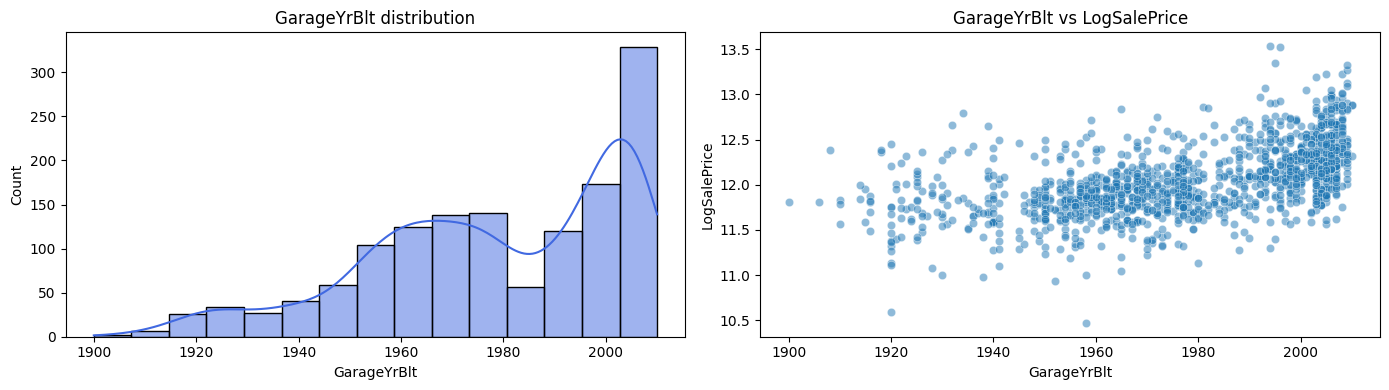

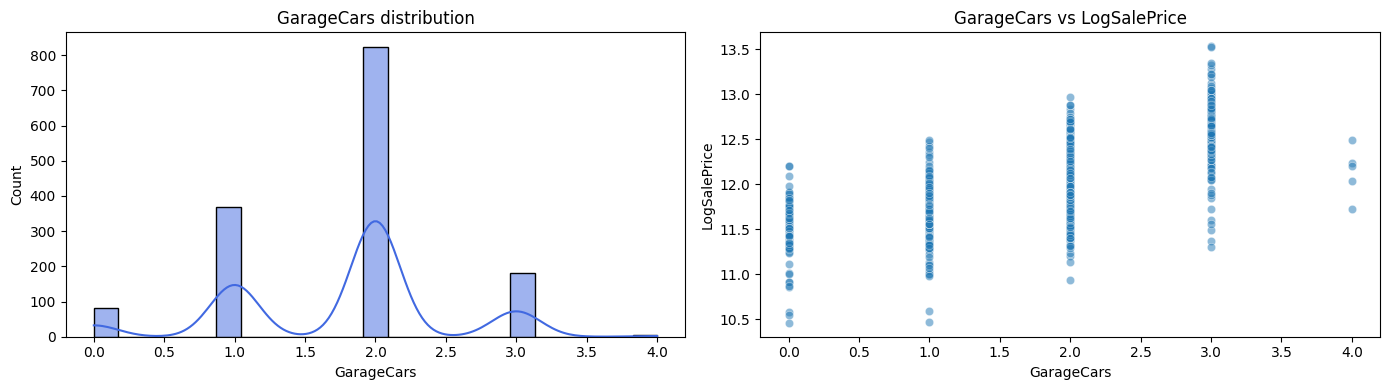

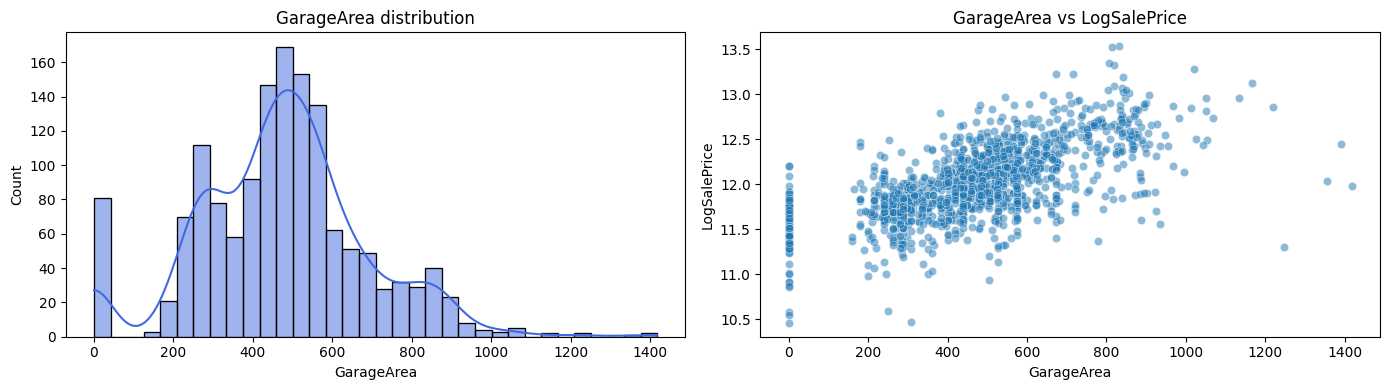

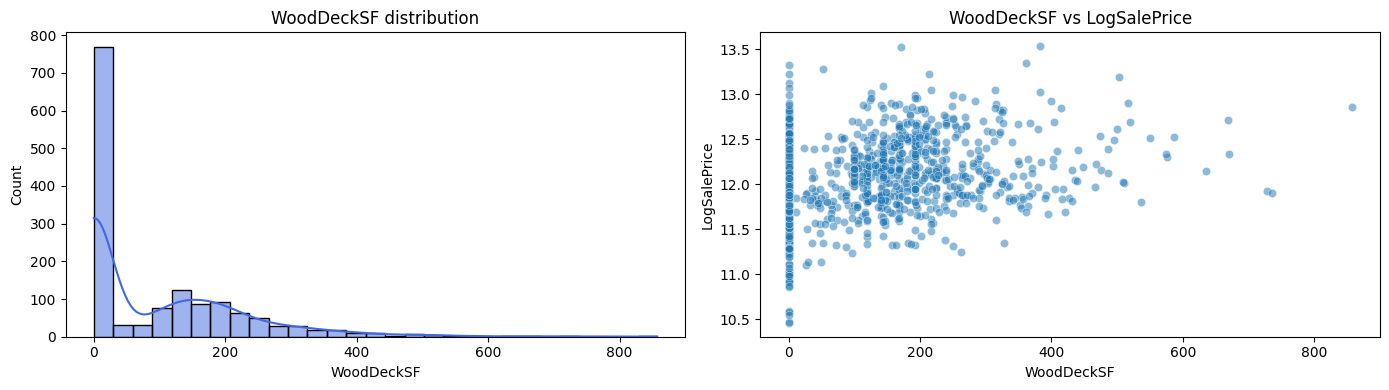

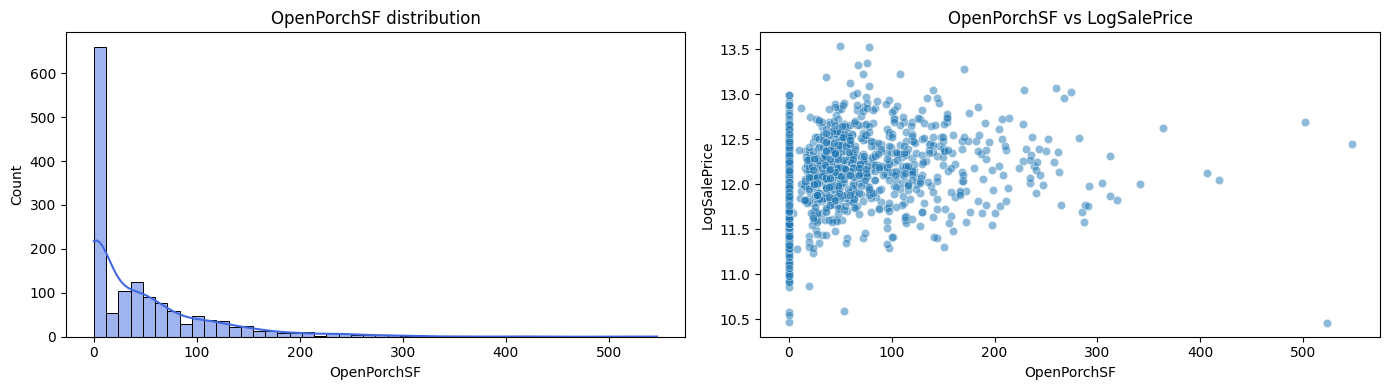

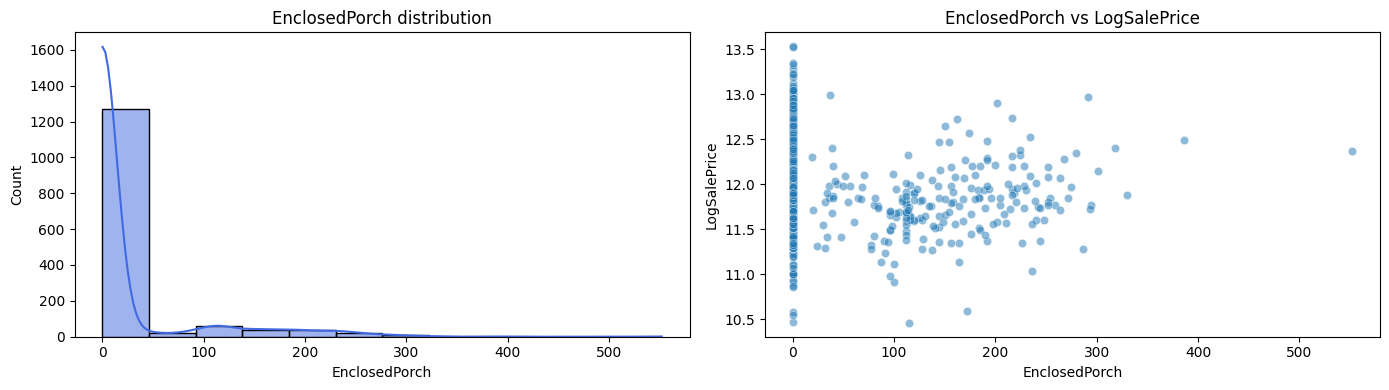

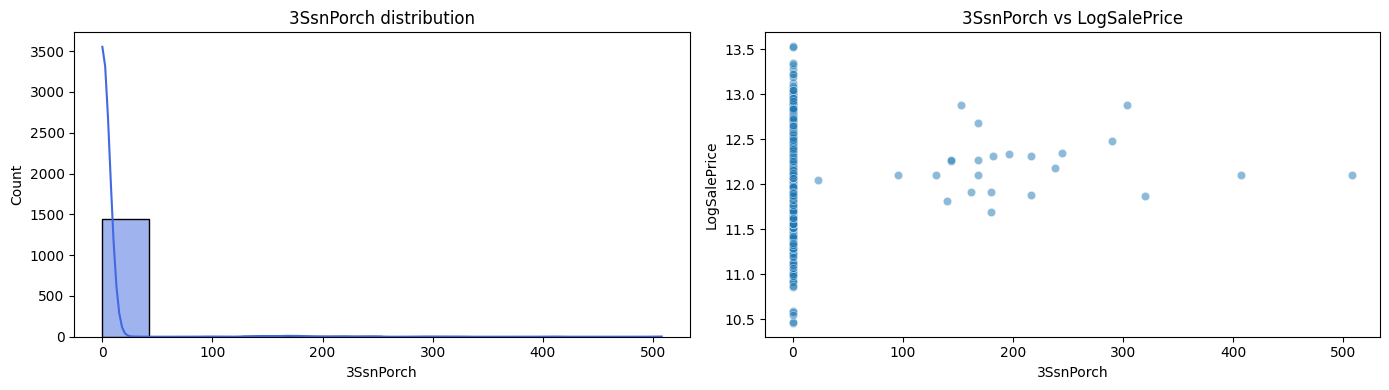

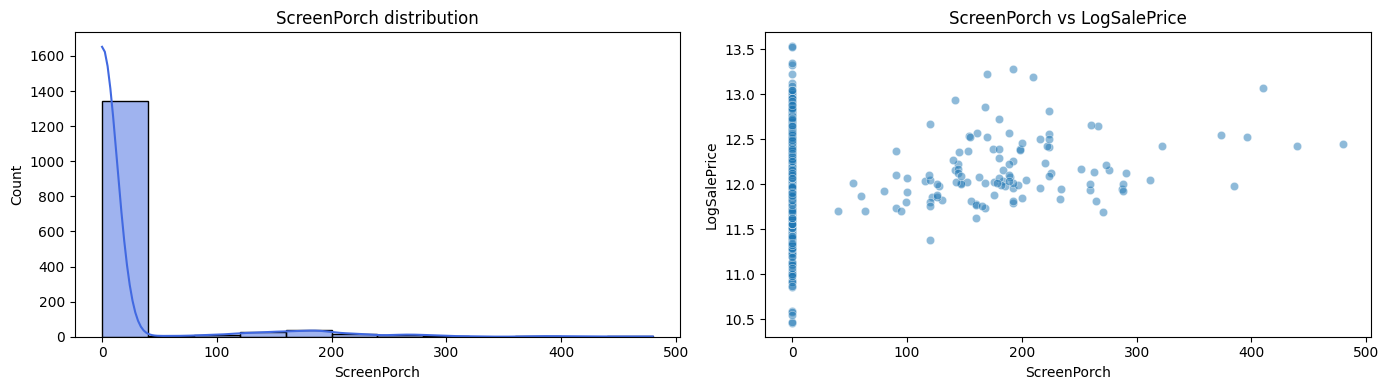

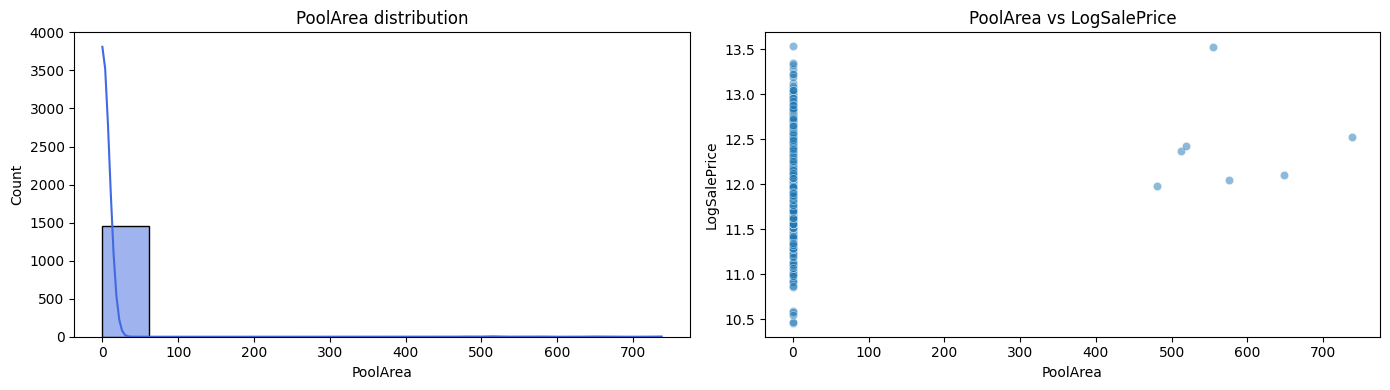

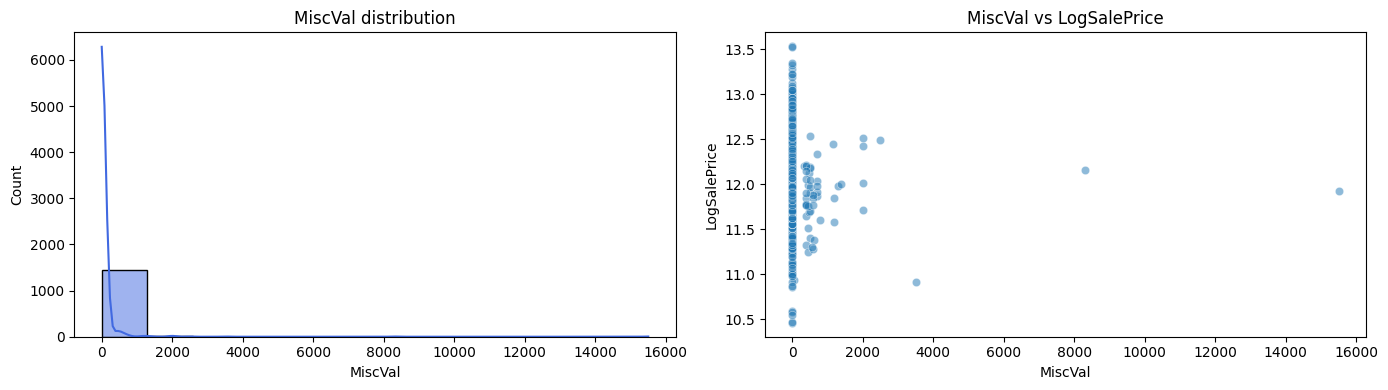

In [58]:
num_feats = ['Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
for col in num_feats:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    sns.histplot(amenity_data[col], kde=True, ax=axes[0], color='royalblue')
    axes[0].set_title(f'{col} distribution')
    sns.scatterplot(x=col, y='LogSalePrice', data=amenity_data, ax=axes[1], alpha=0.5)
    axes[1].set_title(f'{col} vs LogSalePrice')
    plt.tight_layout()
    plt.show()

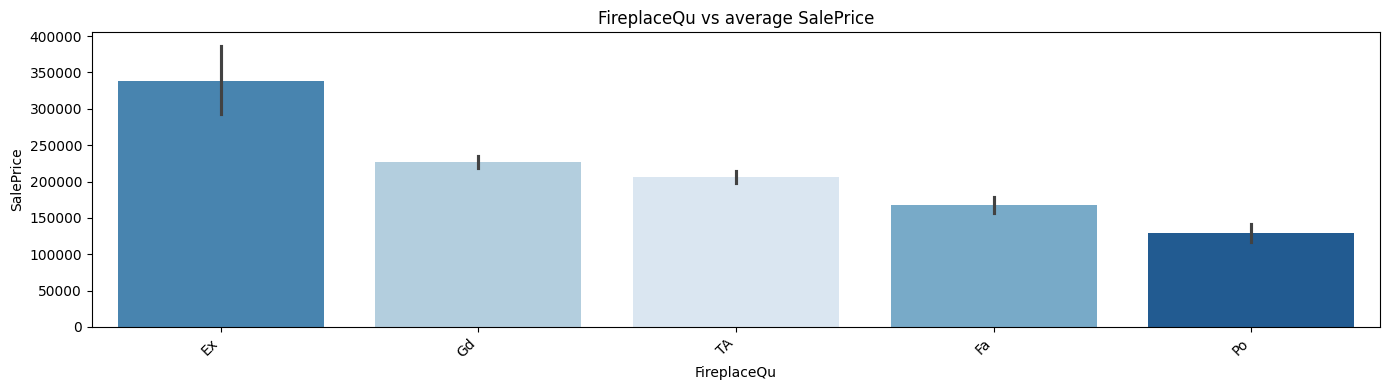

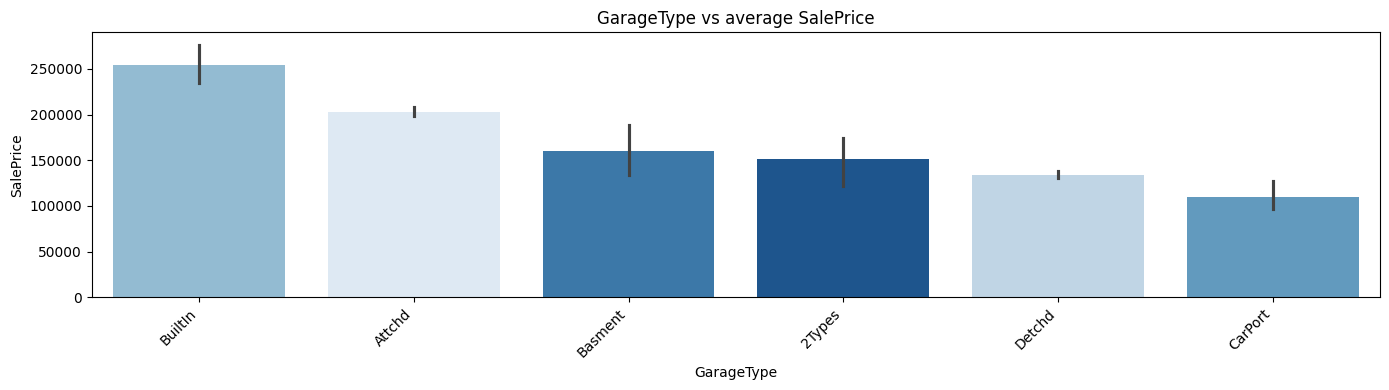

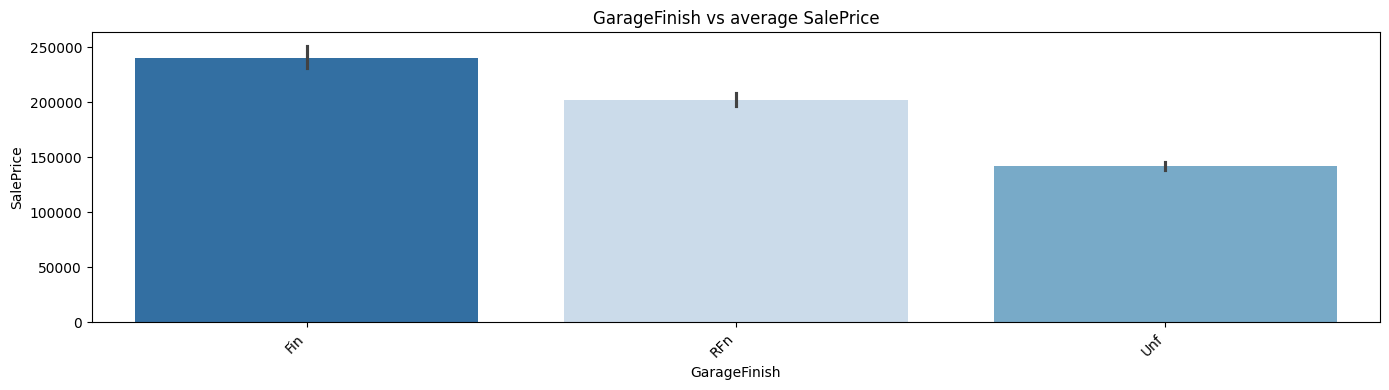

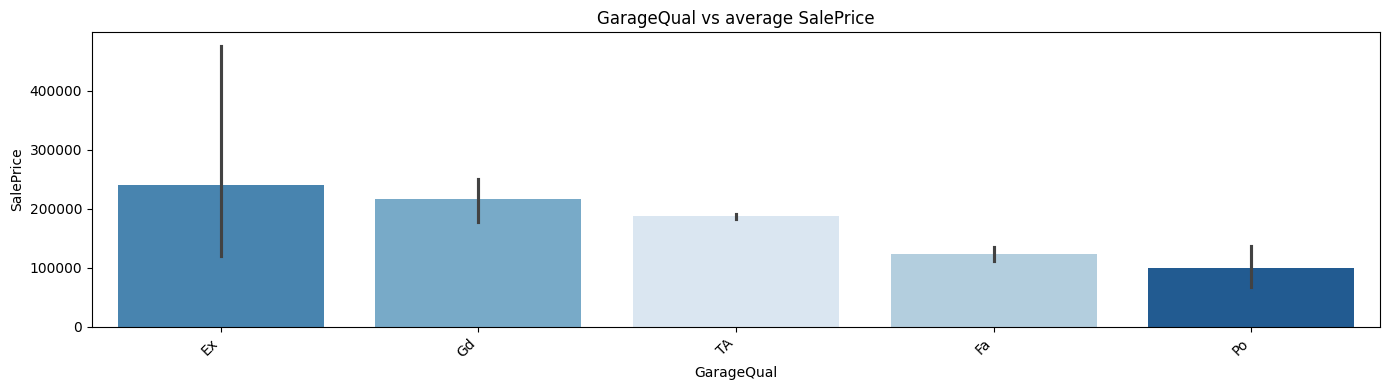

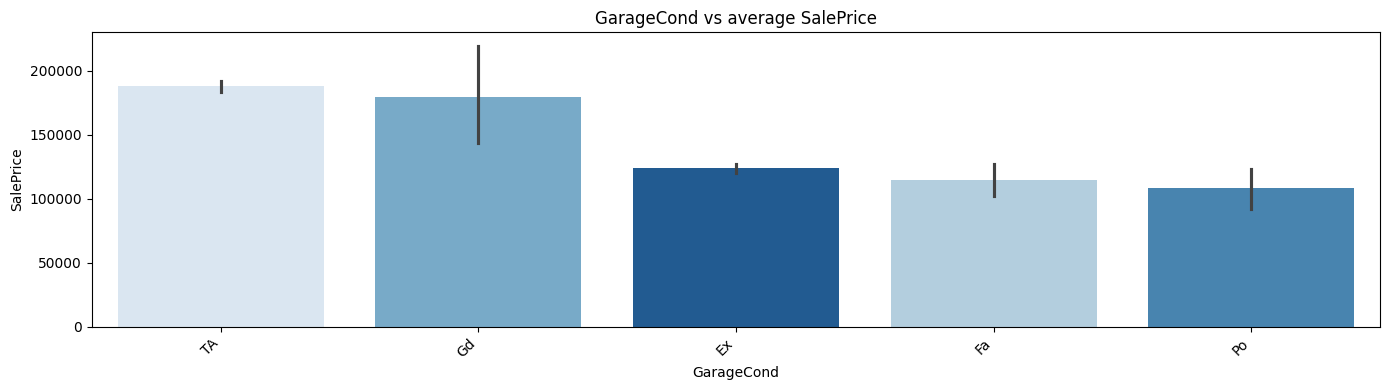

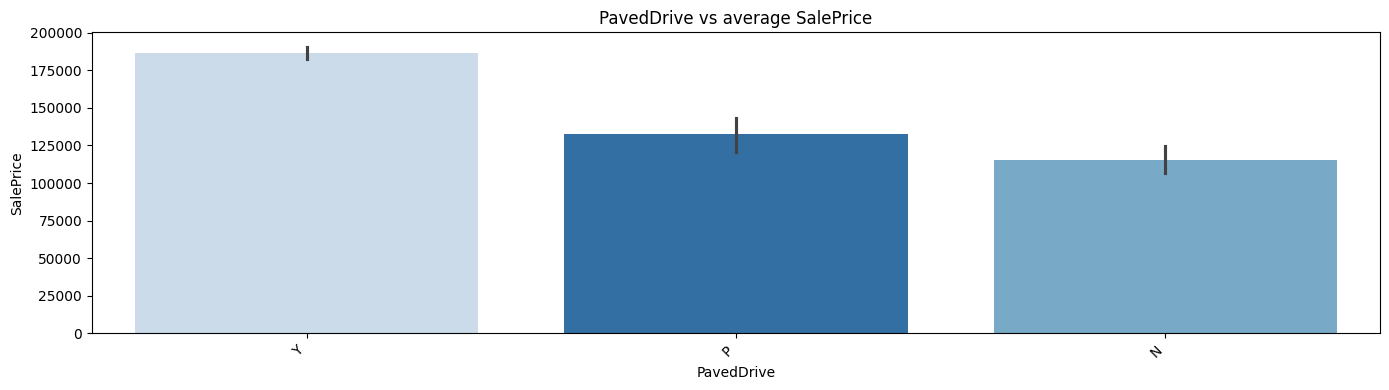

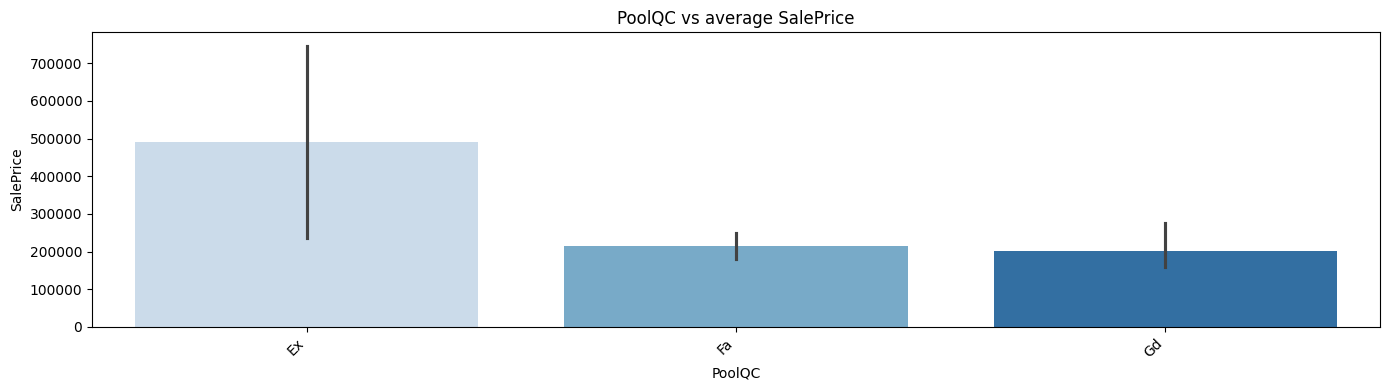

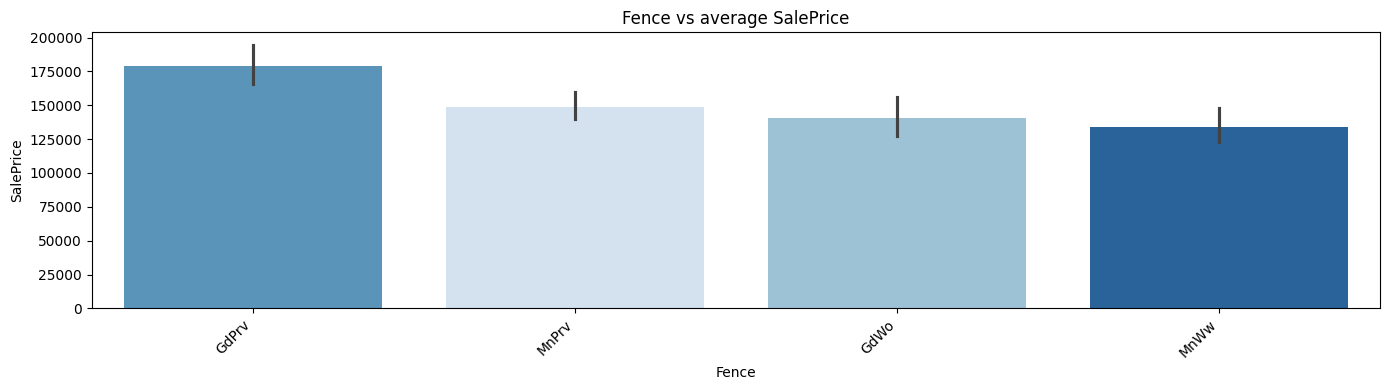

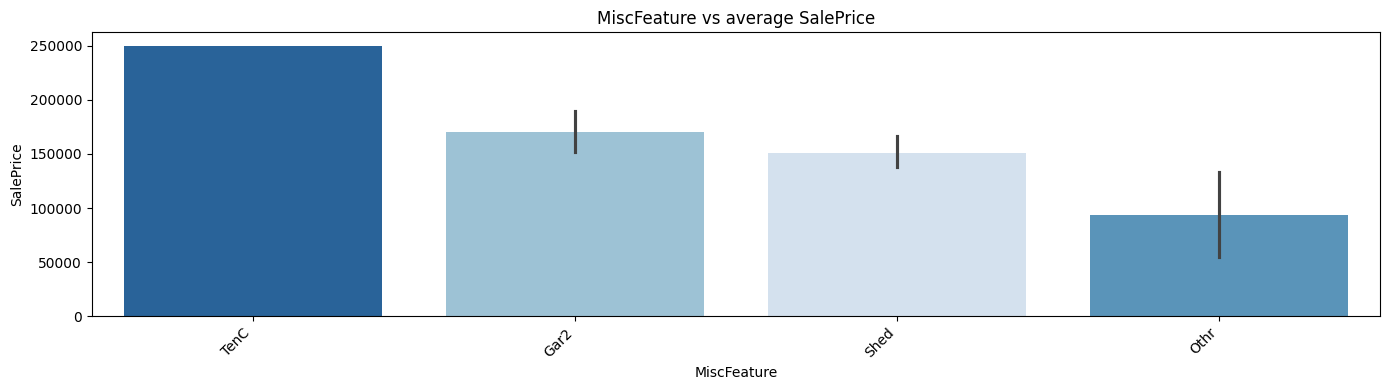

In [59]:
cat_feats = [f for f in amenity_features if f not in num_feats]
for col in cat_feats:
    plt.figure(figsize=(14, 4))
    order = amenity_data.groupby(col)['SalePrice'].mean().sort_values(ascending=False).index
    sns.barplot(x=col, y='SalePrice', data=amenity_data, order=order, palette='Blues', hue=col, legend=False)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{col} vs average SalePrice')
    plt.tight_layout()
    plt.show()

In [60]:
for cat_f in cat_feats:
    amenity_data[f'{cat_f}_num'] = pd.Categorical(amenity_data[cat_f]).codes

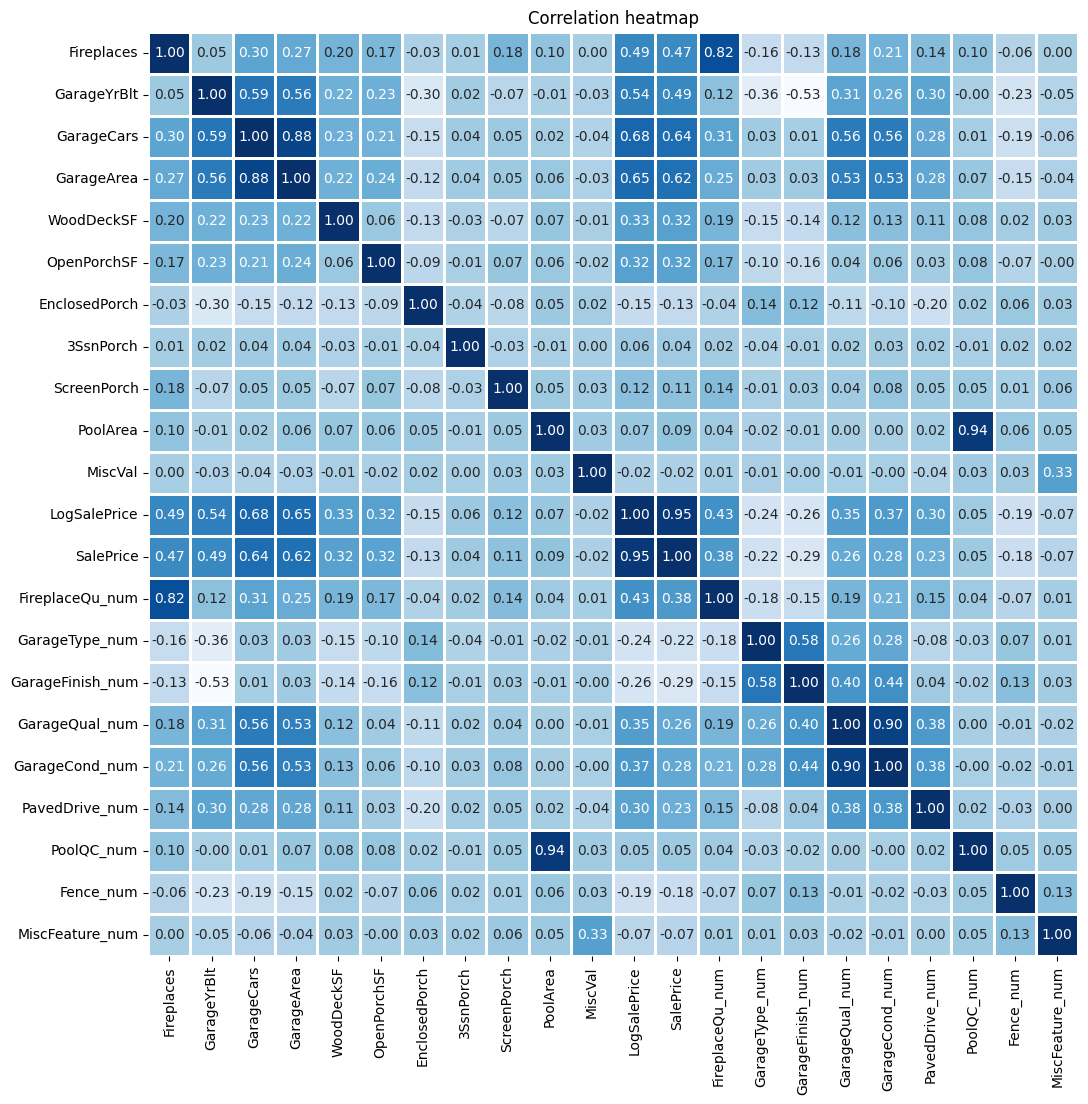

In [61]:
make_heatmap(amenity_data, figsize=(12, 12))

In [62]:
del amenity_data

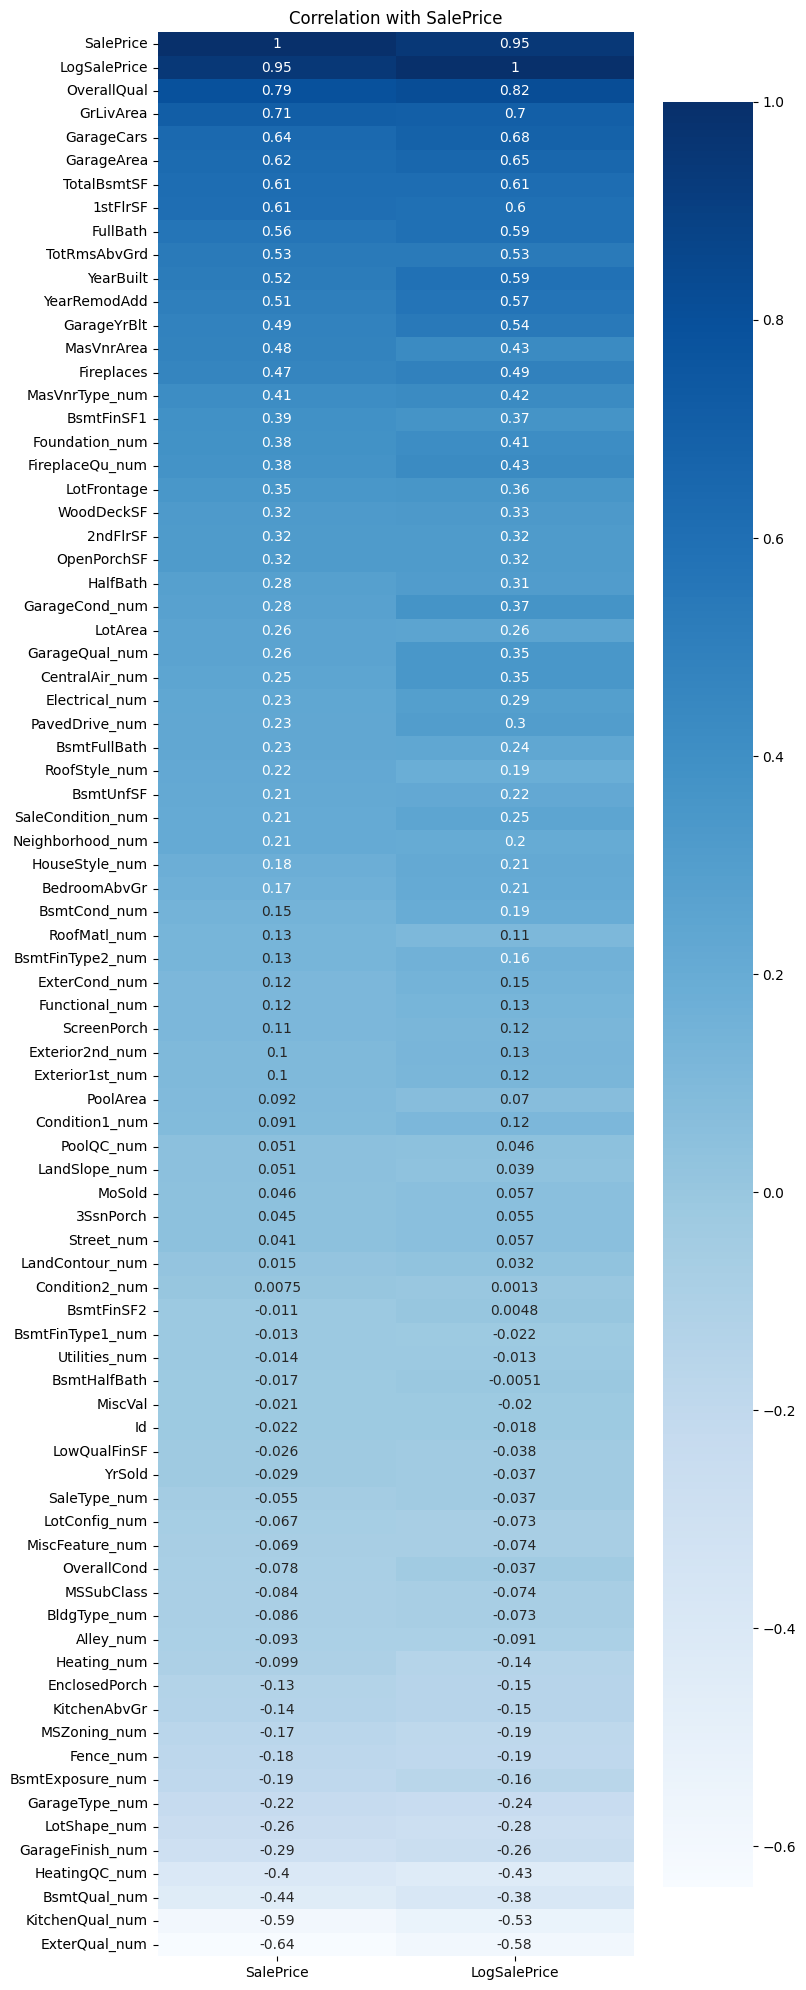

In [63]:
num_cols = list(data.select_dtypes(include=['int64', 'float64']).columns)

for cat_f in data.columns:
    if cat_f not in num_cols:
        data[f'{cat_f}_num'] = pd.Categorical(data[cat_f]).codes
        num_cols.append(f'{cat_f}_num')

corr = data[num_cols].corr(numeric_only=True)
plt.figure(figsize=(8, 20))
sns.heatmap(corr[['SalePrice', 'LogSalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, cmap='Blues')
plt.title('Correlation with SalePrice')
plt.tight_layout()
plt.show()

##### Признаков много, не все из них полезны. На анализ ушло много времени, поэтому пора построить Baseline. Вернемся к признакам позже

### Baseline 1 - CatBoost

In [64]:
data = pd.read_csv('data/train.csv') # будем уверены, что ничего случайно не поменяли
test_data = pd.read_csv('data/test.csv')
X, y = data.drop(labels=['Id', 'SalePrice'], axis=1), data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=18)
cat_features = list(X_train.select_dtypes(exclude=['int', 'float']))
num_features = list(X_train.select_dtypes(include=['int', 'float']))

In [65]:
sm = SimpleImputer()
sm.set_output(transform='pandas')

X_train[num_features] = sm.fit_transform(X_train[num_features])
X_test[num_features] = sm.transform(X_test[num_features])
X_val[num_features] = sm.transform(X_val[num_features])
test_data[num_features] = sm.transform(test_data[num_features])

In [66]:
X_train[cat_features] = X_train[cat_features].fillna('Un')
X_test[cat_features] = X_test[cat_features].fillna('Un')
X_val[cat_features] = X_val[cat_features].fillna('Un')
test_data[cat_features] = test_data[cat_features].fillna('Un')

In [67]:
cbr = CatBoostRegressor(cat_features=cat_features, verbose=100, random_state=123)
cbr.fit(X_train, y_train, eval_set=(X_val, y_val))

Learning rate set to 0.051095
0:	learn: 75174.8801379	test: 82096.3400489	best: 82096.3400489 (0)	total: 86.9ms	remaining: 1m 26s
100:	learn: 22625.2211900	test: 34151.8861693	best: 34151.8861693 (100)	total: 1.58s	remaining: 14.1s
200:	learn: 17157.8798425	test: 31381.6363440	best: 31339.1227270 (198)	total: 2.89s	remaining: 11.5s
300:	learn: 14787.4301710	test: 30863.9742877	best: 30855.9310004 (298)	total: 4.54s	remaining: 10.6s
400:	learn: 12803.7099189	test: 30744.1926768	best: 30688.1911850 (364)	total: 6.33s	remaining: 9.46s
500:	learn: 11223.2181398	test: 30725.6636888	best: 30677.0363386 (491)	total: 8.48s	remaining: 8.44s
600:	learn: 10016.1565498	test: 30645.1808360	best: 30643.9649982 (599)	total: 9.66s	remaining: 6.41s
700:	learn: 8996.2219098	test: 30631.3690434	best: 30603.1045274 (639)	total: 10.6s	remaining: 4.53s
800:	learn: 8180.4726445	test: 30578.0264302	best: 30567.6158576 (773)	total: 11.6s	remaining: 2.87s
900:	learn: 7543.8778582	test: 30614.4216245	best: 30567

In [68]:
print(f'Baseline1 test RMSE: {root_mean_squared_error(y_test, cbr.predict(X_test)):.2f}')

Baseline1 test RMSE: 20038.13


In [69]:
preds = cbr.predict(test_data.drop('Id', axis=1))
test_data['SalePrice'] = preds
(test_data[['Id', 'SalePrice']]).to_csv('submissions/baseline1.csv', index=False)

In [70]:
submissions = api.competition_submissions('house-prices-advanced-regression-techniques')
print(f'Kaggle score: {submissions[-1].to_dict()['publicScore']}')

Kaggle score: 0.12744


### Подберем гиперпараметры с помощью Optuna

In [71]:
def objective(trial : optuna.Trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.001, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0.5, 5.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
        'verbose': 0,
        'random_seed': 18,
        'loss_function': 'RMSE'
    }

    model = CatBoostRegressor(cat_features=cat_features, **params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    preds = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)
    
    return rmse

In [72]:
study = optuna.create_study()
study.optimize(objective, n_trials=30, n_jobs=-1, show_progress_bar=True)

[I 2025-10-19 05:40:53,420] A new study created in memory with name: no-name-6106189d-d954-444a-ab92-c87434cc2ae9


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-19 05:41:09,914] Trial 6 finished with value: 31200.668028638796 and parameters: {'iterations': 394, 'depth': 5, 'learning_rate': 0.040661472120509634, 'l2_leaf_reg': 6.230222697767447, 'bagging_temperature': 0.7026224777951147, 'border_count': 244, 'random_strength': 4.084903413466833, 'min_data_in_leaf': 17}. Best is trial 6 with value: 31200.668028638796.
[I 2025-10-19 05:41:27,136] Trial 2 finished with value: 31800.728466569657 and parameters: {'iterations': 410, 'depth': 7, 'learning_rate': 0.049787747817535026, 'l2_leaf_reg': 0.89378362968248, 'bagging_temperature': 0.6774647359300279, 'border_count': 218, 'random_strength': 4.042314460060241, 'min_data_in_leaf': 4}. Best is trial 6 with value: 31200.668028638796.
[I 2025-10-19 05:41:27,752] Trial 7 finished with value: 33391.88673608517 and parameters: {'iterations': 454, 'depth': 7, 'learning_rate': 0.021648272129649603, 'l2_leaf_reg': 0.07940648526366634, 'bagging_temperature': 0.39974606837716664, 'border_count': 

In [73]:
optuna.visualization.plot_optimization_history(study)

In [74]:
optuna.visualization.plot_param_importances(study)

In [78]:
catboost_with_hp = CatBoostRegressor(**study.best_params, cat_features=cat_features)
catboost_with_hp.fit(pd.concat([X_train, X_val], ignore_index=True), pd.concat([y_train, y_val], ignore_index=True), verbose=100)

0:	learn: 72552.0370814	total: 10.4ms	remaining: 9.8s
100:	learn: 18603.0865282	total: 542ms	remaining: 4.52s
200:	learn: 14540.4775026	total: 1.04s	remaining: 3.84s
300:	learn: 12387.4332532	total: 1.53s	remaining: 3.26s
400:	learn: 10710.9762399	total: 2.11s	remaining: 2.85s
500:	learn: 9540.3393821	total: 2.56s	remaining: 2.26s
600:	learn: 8453.2997820	total: 3.02s	remaining: 1.72s
700:	learn: 7701.4653541	total: 3.52s	remaining: 1.21s
800:	learn: 7157.4316544	total: 3.97s	remaining: 705ms
900:	learn: 6691.4066160	total: 4.43s	remaining: 207ms
942:	learn: 6463.1922763	total: 4.62s	remaining: 0us


In [79]:
print(f'Catboost with parameters test RMSE: {root_mean_squared_error(y_test, catboost_with_hp.predict(X_test)):.2f}')

Catboost with parameters test RMSE: 19364.08


In [81]:
catboost_with_hp = CatBoostRegressor(**study.best_params, cat_features=cat_features)
catboost_with_hp.fit(pd.concat([X_train, X_val, X_test], ignore_index=True), pd.concat([y_train, y_val, y_test], ignore_index=True), verbose=100)

0:	learn: 71917.1580909	total: 6.71ms	remaining: 6.32s
100:	learn: 18203.1739250	total: 504ms	remaining: 4.2s
200:	learn: 14263.2814397	total: 992ms	remaining: 3.66s
300:	learn: 12231.1696167	total: 1.49s	remaining: 3.19s
400:	learn: 10697.3492914	total: 1.91s	remaining: 2.58s
500:	learn: 9596.0044472	total: 2.31s	remaining: 2.04s
600:	learn: 8599.3270794	total: 2.72s	remaining: 1.55s
700:	learn: 7849.7470464	total: 3.14s	remaining: 1.08s
800:	learn: 7219.0375042	total: 3.56s	remaining: 631ms
900:	learn: 6738.4587126	total: 4.03s	remaining: 188ms
942:	learn: 6546.8977273	total: 4.23s	remaining: 0us


In [82]:
preds = catboost_with_hp.predict(test_data.drop('Id', axis=1))
test_data['SalePrice'] = preds
(test_data[['Id', 'SalePrice']]).to_csv('submissions/catboost.csv', index=False)

In [85]:
submissions = api.competition_submissions('house-prices-advanced-regression-techniques')
print(f'Kaggle score: {submissions[0].to_dict()['publicScore']}')

Kaggle score: 0.12305


### Поработаем с данными

In [92]:
data = pd.read_csv('data/train.csv')
data.drop('Id', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data.drop('SalePrice', axis=1), data['SalePrice'], test_size=0.2, random_state=123)

In [93]:
class HouseImputer(BaseEstimator, TransformerMixin):
    def fit(self, X : pd.DataFrame, y=None):
        X = X.copy()
        self.values_for_fill = {}

        catf_for_mode = ['MSZoning', 'Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition', ]
        for f in catf_for_mode:
            self.values_for_fill[f] = X[f].mode()[0]

        numcatf_for_mode = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'MoSold', 'YrSold']
        for f in numcatf_for_mode:
            self.values_for_fill[f] = X[f].astype('category').mode()[0]
        
        numf_for_median = ['BsmtFinSF2', 'LotFrontage', 'LotArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']
        for f in numf_for_median:
            self.values_for_fill[f] = X[f].median()
        

        numcatf_for_mean = ['OverallQual', 'OverallCond']
        for f in numcatf_for_mean:
            self.values_for_fill[f] = int(X[f].mean())
            
        feats_for_na = ['Alley','MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
        for f in feats_for_na:
            self.values_for_fill[f] = 'NA'

        
        feats_for_zero = ['GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
        for f in feats_for_zero:
            self.values_for_fill[f] = 0

        self.values_for_fill['MasVnrArea'] = X['MasVnrArea'].mean()
        self.values_for_fill['TotRmsAbvGrd'] = X['TotRmsAbvGrd'].mean()
        
        return self
    
    def transform(self, X: pd.DataFrame):
        X = X.copy()
        for col, val in self.values_for_fill.items():
            X[col] = X[col].fillna(val)
            
        return X
    
class AddNewFeatures(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X : pd.DataFrame, y=None):
        X = X.copy()
        X['TotalSF'] = X['GrLivArea'] + X['TotalBsmtSF']
        X['TotalPorchSF'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
        X['TotalBath'] = X['FullBath'] + 0.5 * X['HalfBath'] + X['BsmtFullBath'] + 0.5 * X['BsmtHalfBath']
        X['HasFireplace'] = (X['Fireplaces'] > 0).astype(int)
        X['HasGarage'] = (X['GarageType'] == 'NA').astype(int)
        X['HasPool'] = (X['PoolArea'] > 0).astype(int)
        X['QualGrLiv'] = X['OverallQual'] * X['GrLivArea']
        X['QualTotalSF'] = X['OverallQual'] * X['TotalSF']
        return X

In [94]:
category_orders = {
    'MSZoning': ['A', 'I', 'C (all)', 'RM', 'RH', 'RP', 'RL', 'FV'],
    'Street': ['Grvl', 'Pave'],
    'Alley': ['NA', 'Grvl', 'Pave'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'LandContour': ['Low', 'Bnk', 'HLS', 'Lvl'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LotConfig': ['Inside', 'FR2', 'Corner', 'FR3', 'CulDSac'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'Neighborhood': ['MeadowV', 'IDOTRR', 'BrDale', 'OldTown', 'Edwards', 'BrkSide', 'Sawyer',
                     'Blueste', 'SWISU', 'Names', 'Mitchel', 'SawyerW', 'Gilbert', 'NWAmes', 'NAmes',
                     'Blmngtn', 'CollgCr', 'ClearCr', 'Crawfor', 'Veenker', 'Somerst',
                     'Timber', 'StoneBr', 'NoRidge', 'NridgHt', 'NPkVill'],
    'Condition1': ['RRAe', 'RRNe', 'Artery', 'Feedr', 'RRNn', 'RRAn', 'Norm', 'PosN', 'PosA'],
    'Condition2': ['RRAe', 'RRNe', 'Artery', 'Feedr', 'RRNn', 'RRAn', 'Norm', 'PosN', 'PosA'],
    'BldgType': ['1Fam', 'Duplex', 'TwnhsE', '2fmCon', 'Twnhs'],
    'HouseStyle': ['1.5Unf', '1Story', 'SFoyer', 'SLvl', '1.5Fin', '2Story', '2.5Unf', '2.5Fin'],
    'RoofStyle': ['Flat', 'Shed', 'Mansard', 'Gambrel', 'Gable', 'Hip'],
    'RoofMatl': ['Roll', 'Tar&Grv', 'WdShake', 'WdShngl', 'Membran', 'Metal', 'CompShg', 'ClyTile'],
    'Exterior1st': ['AsbShng', 'AsphShn', 'CBlock', 'BrkComm', 'WdShing', 'Stucco', 'Wd Sdng',
                    'MetalSd', 'Plywood', 'HdBoard', 'ImStucc', 'BrkFace', 'CemntBd', 'VinylSd',
                    'Stone', 'PreCast', 'Other'],
    'Exterior2nd': ['AsbShng', 'AsphShn', 'CBlock', 'Brk Cmn', 'Wd Sdng', 'Stucco','Wd Shng',
                    'MetalSd', 'Plywood', 'HdBoard', 'ImStucc', 'BrkFace', 'CmentBd', 'VinylSd',
                    'Stone', 'PreCast', 'Other'],
    'MasVnrType': ['NA', 'BrkCmn', 'CBlock', 'BrkFace', 'Stone'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Foundation': ['Slab', 'Stone', 'Wood', 'BrkTil', 'CBlock', 'PConc'],
    'BsmtQual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['NA', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'Heating': ['Wall', 'Grav', 'Floor', 'OthW', 'GasW', 'GasA'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'CentralAir': ['N', 'Y'],
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageType': ['NA', 'CarPort', 'Detchd', 'Basment', 'Attchd', 'BuiltIn', '2Types'],
    'GarageFinish': ['NA', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['NA', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['NA', 'MnWw', 'MnPrv', 'GdWo', 'GdPrv'],
    'MiscFeature': ['NA', 'Othr', 'Shed', 'Gar2', 'TenC', 'Elev'],
    'SaleType': ['Oth', 'ConLD', 'ConLI', 'ConLw', 'COD', 'Con', 'VWD', 'CWD', 'WD', 'New'],
    'SaleCondition': ['Partial', 'Family', 'Abnorml', 'AdjLand', 'Alloca', 'Normal']
}

class HouseEncoder(TransformerMixin, BaseEstimator):
    def __init__(self, cat_features):
        self.cat_features = cat_features
        self.encoders = {}

    def fit(self, X, y=None):
        for feature in self.cat_features:
            self.encoders[feature] = OrdinalEncoder(categories=[category_orders[feature]]).fit(X[[feature]])
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for feature in self.cat_features:
            X[feature] = self.encoders[feature].transform(X[[feature]])
        return X

In [95]:
cat_features = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
num_features = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'TotalSF', 'TotalPorchSF', 'TotalBath', 'HasFireplace', 'HasGarage', 'HasPool', 'QualGrLiv', 'QualTotalSF']

pipline_without_scaling = Pipeline([
    ('Imputer', HouseImputer()),
    ('New Features', AddNewFeatures()),
    ('Encoder', HouseEncoder(cat_features)),
])

In [96]:
X_train = pipline_without_scaling.fit_transform(X_train)
X_test = pipline_without_scaling.transform(X_test)

In [97]:
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train)

print(f'RF RMSE train set: {root_mean_squared_error(y_train, rf.predict(X_train)):.3f}')
print(f'RF RMSE test set: {root_mean_squared_error(y_test, rf.predict(X_test)):.3f}')

RF RMSE train set: 11382.323
RF RMSE test set: 24370.120


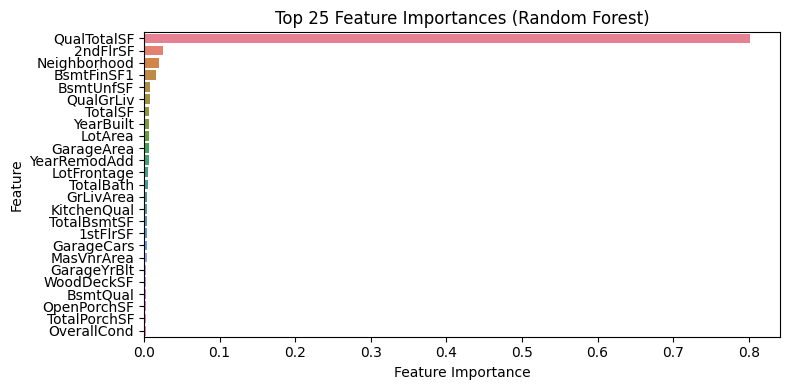

In [98]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 4))
sns.barplot(x=importances[indices][:25], y=np.array(X_train.columns)[indices][:25], orient='h', hue=np.array(X_train.columns)[indices][:25], legend=False)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 25 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

In [99]:
scaler = MinMaxScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
lr = LinearRegression().fit(X_train_scaled, y_train)

In [100]:
print(f'LR RMSE train set: {root_mean_squared_error(y_train, lr.predict(X_train_scaled)):.3f}')
print(f'LR RMSE test set: {root_mean_squared_error(y_test, lr.predict(X_test_scaled)):.3f}')

LR RMSE train set: 29568.877
LR RMSE test set: 70322.649


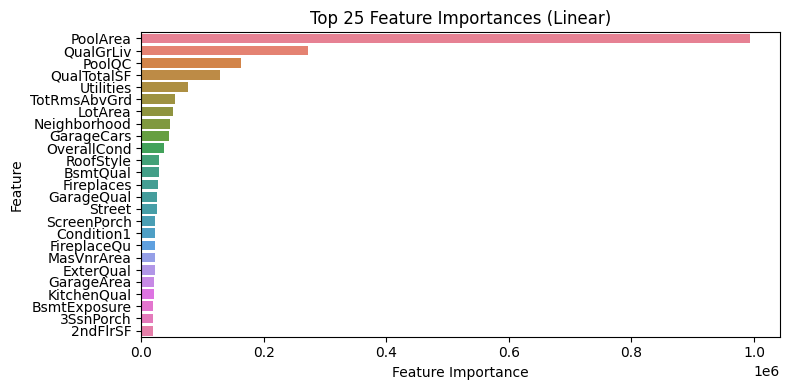

In [101]:
importances = lr.coef_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 4))
sns.barplot(x=importances[indices][:25], y=np.array(lr.feature_names_in_)[indices][:25], orient='h', hue=np.array(lr.feature_names_in_)[indices][:25], legend=False)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 25 Feature Importances (Linear)')
plt.tight_layout()
plt.show()

#### Снова попробуем CatBoost

In [102]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=33)

In [112]:
def objective(trial : optuna.Trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1300),
        'depth': trial.suggest_int('depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.001, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 2.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0.5, 10.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
        'verbose': 0,
        'random_seed': 18,
        'loss_function': 'RMSE',
        'early_stopping_rounds': 100
    }

    model = CatBoostRegressor(**params)
    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)
    model.fit(train_pool, eval_set=val_pool, verbose=False)
    
    preds = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)
    
    return rmse

In [113]:
study = optuna.create_study()
study.optimize(objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2025-10-19 06:04:59,092] A new study created in memory with name: no-name-21edfb53-3e2e-4962-8962-7443a26b2f94


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-19 06:05:00,207] Trial 0 finished with value: 26727.404806677943 and parameters: {'iterations': 442, 'depth': 4, 'learning_rate': 0.023260498878606147, 'l2_leaf_reg': 7.086078326444523, 'bagging_temperature': 0.8335908958102423, 'border_count': 167, 'random_strength': 8.851547725334237, 'min_data_in_leaf': 8}. Best is trial 0 with value: 26727.404806677943.
[I 2025-10-19 06:05:00,687] Trial 7 finished with value: 24812.194329727612 and parameters: {'iterations': 790, 'depth': 4, 'learning_rate': 0.08007382703744025, 'l2_leaf_reg': 0.00512206602333965, 'bagging_temperature': 1.9982975273785104, 'border_count': 82, 'random_strength': 3.6029577742856724, 'min_data_in_leaf': 12}. Best is trial 7 with value: 24812.194329727612.
[I 2025-10-19 06:05:02,179] Trial 8 finished with value: 23267.353800027096 and parameters: {'iterations': 519, 'depth': 5, 'learning_rate': 0.17196921396396503, 'l2_leaf_reg': 7.346369325838566, 'bagging_temperature': 0.9211167646525764, 'border_count': 2

In [114]:
optuna.visualization.plot_optimization_history(study)

In [115]:
optuna.visualization.plot_param_importances(study)

In [128]:
catboost_with_hp = CatBoostRegressor(**study.best_params)
catboost_with_hp.fit(Pool(X_train, y_train), eval_set=Pool(X_val, y_val), verbose=100)

0:	learn: 68269.2602325	test: 67783.8075638	best: 67783.8075638 (0)	total: 3.48ms	remaining: 3.25s
100:	learn: 7501.5928513	test: 24097.9894727	best: 24062.0964420 (97)	total: 117ms	remaining: 962ms
200:	learn: 3066.7011667	test: 24327.4699113	best: 24034.1681940 (120)	total: 210ms	remaining: 767ms
300:	learn: 1497.1805421	test: 24300.5179289	best: 24034.1681940 (120)	total: 317ms	remaining: 668ms
400:	learn: 744.6024309	test: 24288.4686787	best: 24034.1681940 (120)	total: 400ms	remaining: 533ms
500:	learn: 404.2431649	test: 24296.6353857	best: 24034.1681940 (120)	total: 487ms	remaining: 422ms
600:	learn: 211.6626284	test: 24298.9797333	best: 24034.1681940 (120)	total: 574ms	remaining: 319ms
700:	learn: 115.7404487	test: 24303.9297389	best: 24034.1681940 (120)	total: 671ms	remaining: 224ms
800:	learn: 63.7601540	test: 24303.0016331	best: 24034.1681940 (120)	total: 775ms	remaining: 130ms
900:	learn: 35.8119010	test: 24303.3009014	best: 24034.1681940 (120)	total: 858ms	remaining: 32.4ms


In [129]:
print(f'Catboost with parameters test RMSE: {root_mean_squared_error(y_test, catboost_with_hp.predict(X_test)):.2f}')

Catboost with parameters test RMSE: 28523.80


In [130]:
test_data = pd.read_csv('data/test.csv')
X_for_subm = pipline_without_scaling.transform(test_data)

In [131]:
X_for_subm['SalePrice'] = catboost_with_hp.predict(X_for_subm.drop('Id', axis=1))

In [132]:
(X_for_subm[['Id', 'SalePrice']]).to_csv('submissions/catboost_with_fe_and_hyp.csv', index=False)

In [134]:
submissions = api.competition_submissions('house-prices-advanced-regression-techniques')
print(f'Kaggle score: {submissions[5].to_dict()['publicScore']}')

Kaggle score: 0.12667


#### Качество стало чуть лучше, обучим на всем сете

In [135]:
train = pd.read_csv('data/train.csv')
X_train, y_train = train.drop(['Id', 'SalePrice'], axis=1), train['SalePrice']
test_data = pd.read_csv('data/test.csv')
X_train = pipline_without_scaling.fit_transform(X_train)
X_for_subm = pipline_without_scaling.transform(test_data.drop('Id', axis=1))

In [136]:
catboost_with_hp.fit(Pool(X_train, y_train), verbose=100, use_best_model=True)
test_data['SalePrice'] = catboost_with_hp.predict(X_for_subm)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 67182.6247875	total: 2.77ms	remaining: 2.59s
100:	learn: 8446.2477937	total: 99.8ms	remaining: 824ms
200:	learn: 3832.6491264	total: 187ms	remaining: 684ms
300:	learn: 2029.9186653	total: 289ms	remaining: 609ms
400:	learn: 1171.6659747	total: 387ms	remaining: 515ms
500:	learn: 672.5305117	total: 475ms	remaining: 412ms
600:	learn: 404.6685268	total: 566ms	remaining: 314ms
700:	learn: 238.8625458	total: 653ms	remaining: 218ms
800:	learn: 147.3919554	total: 748ms	remaining: 125ms
900:	learn: 92.1406323	total: 983ms	remaining: 37.1ms
934:	learn: 78.5604390	total: 1.02s	remaining: 0us


In [137]:
(test_data[['Id', 'SalePrice']]).to_csv('submissions/catboost_with_fe_and_hyp_allset.csv', index=False)

In [139]:
submissions = api.competition_submissions('house-prices-advanced-regression-techniques')
print(f'Kaggle score: {submissions[4].to_dict()['publicScore']}')

Kaggle score: 0.12419


#### Еще немного подняли качество

### Стекинг

In [159]:
data = pd.read_csv('data/train.csv').drop('Id', axis=1)
X, y = data.drop('SalePrice', axis=1), data['SalePrice']

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

In [161]:
pipline_without_scaling.fit(X_train)
X_train = pipline_without_scaling.transform(X_train)
X_test = pipline_without_scaling.transform(X_test)

In [162]:
kfold = KFold(n_splits=10, shuffle=True, random_state=18)

In [163]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.5, 2.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
        'loss_function': 'RMSE',
        'verbose': 0,
        'random_seed': 42,
    }

    rmses = []
    for tr_idx, val_idx in kfold.split(X_train):
        X_t, X_v = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        model = CatBoostRegressor(**params)
        model.fit(Pool(X_t, y_t), eval_set=Pool(X_v, y_v), verbose=False)
        preds = model.predict(X_v)
        rmses.append(root_mean_squared_error(y_v, preds))
    return np.mean(rmses)

study_cat = optuna.create_study()
study_cat.optimize(objective_cat, n_trials=20, show_progress_bar=True, n_jobs=-1)
cat_params = study_cat.best_params


[I 2025-10-19 06:19:27,340] A new study created in memory with name: no-name-fd667972-26a3-463b-96a4-f53cf1895daa


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-19 06:19:48,115] Trial 1 finished with value: 24963.102282184795 and parameters: {'iterations': 679, 'depth': 4, 'learning_rate': 0.16474327708155562, 'l2_leaf_reg': 9.599664264815509, 'bagging_temperature': 0.5719904766671845, 'random_strength': 1.2542351670228047, 'min_data_in_leaf': 50}. Best is trial 1 with value: 24963.102282184795.
[I 2025-10-19 06:20:10,160] Trial 5 finished with value: 24315.37067431012 and parameters: {'iterations': 657, 'depth': 6, 'learning_rate': 0.06385888346113915, 'l2_leaf_reg': 6.717825668162646, 'bagging_temperature': 0.6386601925090637, 'random_strength': 1.3517617380098557, 'min_data_in_leaf': 16}. Best is trial 5 with value: 24315.37067431012.
[I 2025-10-19 06:20:14,170] Trial 4 finished with value: 24988.79975578271 and parameters: {'iterations': 1127, 'depth': 5, 'learning_rate': 0.03520706724626252, 'l2_leaf_reg': 3.612031847974385, 'bagging_temperature': 0.193373718660533, 'random_strength': 0.7343636299374179, 'min_data_in_leaf': 25}

In [165]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 5.0),
        'random_state': 42,
        'n_jobs': -1
    }

    rmses = []
    for tr_idx, val_idx in kfold.split(X_train):
        X_t, X_v = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        model = XGBRegressor(**params)
        model.fit(X_t, y_t, eval_set=[(X_v, y_v)], verbose=False)
        preds = model.predict(X_v)
        rmses.append(root_mean_squared_error(y_v, preds))
    return np.mean(rmses)

study_xgb = optuna.create_study()
study_xgb.optimize(objective_xgb, n_trials=20, show_progress_bar=True, n_jobs=-1)
xgb_params = study_xgb.best_params


[I 2025-10-19 06:35:00,168] A new study created in memory with name: no-name-55e8ed1a-c2ea-45da-a2bb-8094ad9bc706


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-19 06:37:41,422] Trial 4 finished with value: 25188.3162109375 and parameters: {'n_estimators': 680, 'max_depth': 3, 'learning_rate': 0.028063133700809925, 'subsample': 0.6403832229524031, 'colsample_bytree': 0.6004869872174435, 'reg_lambda': 3.385958245203918}. Best is trial 4 with value: 25188.3162109375.
[I 2025-10-19 06:38:18,881] Trial 0 finished with value: 26693.0916015625 and parameters: {'n_estimators': 904, 'max_depth': 4, 'learning_rate': 0.10099549776292373, 'subsample': 0.788549065537748, 'colsample_bytree': 0.979568581346586, 'reg_lambda': 4.199272035368024}. Best is trial 4 with value: 25188.3162109375.
[I 2025-10-19 06:38:31,046] Trial 6 finished with value: 26022.3388671875 and parameters: {'n_estimators': 860, 'max_depth': 5, 'learning_rate': 0.07325539892626318, 'subsample': 0.6494212554854133, 'colsample_bytree': 0.9834478850221708, 'reg_lambda': 4.3890451775251265}. Best is trial 4 with value: 25188.3162109375.
[I 2025-10-19 06:39:14,707] Trial 3 finishe

In [166]:
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 5.0),
        'num_leaves': trial.suggest_int('num_leaves', 16, 128),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    rmses = []
    for tr_idx, val_idx in kfold.split(X_train):
        X_t, X_v = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        model = LGBMRegressor(**params)
        model.fit(X_t, y_t, eval_set=[(X_v, y_v)])
        preds = model.predict(X_v)
        rmses.append(root_mean_squared_error(y_v, preds))
    return np.mean(rmses)

study_lgbm = optuna.create_study()
study_lgbm.optimize(objective_lgbm, n_trials=20, show_progress_bar=True, n_jobs=-1)
lgbm_params = study_lgbm.best_params


[I 2025-10-19 06:42:38,474] A new study created in memory with name: no-name-c8e3a19b-6f54-459f-9982-a7f99c1eb866


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-19 06:43:30,685] Trial 5 finished with value: 28370.104928187742 and parameters: {'n_estimators': 641, 'max_depth': 4, 'learning_rate': 0.055941721183858185, 'subsample': 0.7851165304219443, 'colsample_bytree': 0.8609719386422179, 'reg_lambda': 3.8002763330779774, 'num_leaves': 38, 'min_child_samples': 30}. Best is trial 5 with value: 28370.104928187742.
[I 2025-10-19 06:43:34,078] Trial 4 finished with value: 27922.612962838182 and parameters: {'n_estimators': 795, 'max_depth': 3, 'learning_rate': 0.020486466541281292, 'subsample': 0.7691412681838213, 'colsample_bytree': 0.981381295689465, 'reg_lambda': 4.44584182714938, 'num_leaves': 90, 'min_child_samples': 15}. Best is trial 4 with value: 27922.612962838182.
[I 2025-10-19 06:43:59,897] Trial 6 finished with value: 28267.609155400307 and parameters: {'n_estimators': 513, 'max_depth': 5, 'learning_rate': 0.25554913530564144, 'subsample': 0.8374860793780732, 'colsample_bytree': 0.6410180937433057, 'reg_lambda': 4.5819261539

In [168]:
meta_train = np.zeros((X_train.shape[0], 3))
meta_test = np.zeros((X_test.shape[0], 3))
kfold = KFold(n_splits=10, shuffle=True, random_state=18)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
    X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

    cat = CatBoostRegressor(**cat_params)
    cat.fit(Pool(X_t, y_t), eval_set=Pool(X_v, y_v), verbose=False, use_best_model=True)
    meta_train[val_idx, 0] = cat.predict(X_v)
    meta_test[:, 0] += cat.predict(X_test) / kfold.n_splits

    xgb = XGBRegressor(**xgb_params)
    xgb.fit(X_t, y_t, eval_set=[(X_v, y_v)], verbose=False)
    meta_train[val_idx, 1] = xgb.predict(X_v)
    meta_test[:, 1] += xgb.predict(X_test) / kfold.n_splits

    lgb = LGBMRegressor(**lgbm_params, verbose=-1)
    lgb.fit(X_t, y_t, eval_set=[(X_v, y_v)])
    meta_train[val_idx, 2] = lgb.predict(X_v)
    meta_test[:, 2] += lgb.predict(X_test) / kfold.n_splits

meta_model = Ridge()
meta_model.fit(meta_train, y_train)
preds = meta_model.predict(meta_test)

rmse_final = root_mean_squared_error(y_test, preds)
print(f'Stacking model test RMSE: {rmse_final:.4f}')

Stacking model test RMSE: 25951.7617


In [169]:
test_data = pd.read_csv('data/test.csv')
X_for_subm = pipline_without_scaling.transform(test_data.drop('Id', axis=1))

cat_preds = cat.predict(X_for_subm)
xgb_preds = xgb.predict(X_for_subm)
lgbm_preds = lgb.predict(X_for_subm)

meta_preds = np.column_stack([cat_preds, xgb_preds, lgbm_preds])
final_preds = meta_model.predict(meta_preds)

test_data['SalePrice'] = final_preds

In [170]:
(test_data[['Id', 'SalePrice']]).to_csv('submissions/stacking.csv', index=False)

In [171]:
submissions = api.competition_submissions('house-prices-advanced-regression-techniques')
print(f'Kaggle score: {submissions[0].to_dict()['publicScore']}')

Kaggle score: 0.12589


In [174]:
train = pd.read_csv('data/train.csv')
X_train, y_train = train.drop(['SalePrice', 'Id'], axis=1), train['SalePrice']
X_train = pipline_without_scaling.fit_transform(X_train)

test_data = pd.read_csv('data/test.csv')
X_for_subm = pipline_without_scaling.transform(test_data.drop('Id', axis=1))


cat = CatBoostRegressor(**cat_params)
cat.fit(X_train, y_train, verbose=100)
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train, y_train)
lgb = LGBMRegressor(**lgbm_params, verbose=-1)
lgb.fit(X_train, y_train)

0:	learn: 76156.4275766	total: 5.91ms	remaining: 3.88s
100:	learn: 20199.8549539	total: 162ms	remaining: 891ms
200:	learn: 16067.9104553	total: 329ms	remaining: 747ms
300:	learn: 13565.9875020	total: 482ms	remaining: 570ms
400:	learn: 11656.7002349	total: 635ms	remaining: 406ms
500:	learn: 10112.0381306	total: 794ms	remaining: 247ms
600:	learn: 8854.2735204	total: 973ms	remaining: 90.6ms
656:	learn: 8311.1494260	total: 1.11s	remaining: 0us


LGBMRegressor(colsample_bytree=0.6313885973825906,
              learning_rate=0.0102965082402124, max_depth=7,
              min_child_samples=35, n_estimators=1106, num_leaves=128,
              reg_lambda=1.7185222201004255, subsample=0.86432021179546,
              verbose=-1)

In [182]:
cat_preds = cat.predict(X_train)
xgb_preds = xgb.predict(X_train)
lgbm_preds = lgb.predict(X_train)

In [ ]:
meta_preds = np.column_stack([cat_preds, xgb_preds, lgbm_preds])

meta_model.fit(meta_preds, y_train)

cat_preds = cat.predict(X_for_subm)
xgb_preds = xgb.predict(X_for_subm)
lgbm_preds = lgb.predict(X_for_subm)

meta_preds = np.column_stack([cat_preds, xgb_preds, lgbm_preds])
final_preds = meta_model.predict(meta_preds)

test_data['SalePrice'] = final_preds

(test_data[['Id', 'SalePrice']]).to_csv('submissions/stacking_allset.csv', index=False)

(1460, 3) (1460,)


In [185]:
submissions = api.competition_submissions('house-prices-advanced-regression-techniques')
print(f'Kaggle score: {submissions[0].to_dict()['publicScore']}')

Kaggle score: 0.12947
